In [ ]:
# ================================================================================
# Import packages and Data
# ================================================================================

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.formula.api as smf
import statsmodels.api as sm
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

data=pd.read_csv('vehicles.csv')

Mounted at /content/gdrive


In [ ]:
# ================================================================================
# Data Cleaning - Choosing variables and filtering out irrelevant entries
# ================================================================================
# data=pd.read_csv('vehicles.csv')
variables = ['comb08','displ','atvType','barrels08','city08','co2TailpipeGpm','cylinders','drive','feScore',
             'fuelCost08','fuelType','ghgScore','highway08','hlv','hpv','lv2','lv4','mpgData',
             'pv2','pv4','UCity','UHighway','year','guzzler','tCharger','sCharger','startStop','trany','VClass']
data2 = data[variables]

# Only cars made in year 1984-2021 should be included.
data2 = data2[data2.year.isin(range(1984,2021))]

# only vehicles with these fuel types are considered
data2 = data2[data2.fuelType.isin(['Regular', 'Premium', 'Diesel', 'Midgrade'])]
data2 = data2[~data2.atvType.isin(['Hybrid'])]
variables.remove('atvType')
data2.drop(columns = ['atvType'], inplace = True)
data2['Premium']=np.where(data2['fuelType']=='Premium',1,0)
data2['Diesel']=np.where(data2['fuelType']=='Diesel',1,0)
data2['Midgrade']=np.where(data2['fuelType']=='Midgrade',1,0)

# Converting sCharger and tCharger to dummy variables
data2.tCharger.replace([np.nan,'T'],[0,1],inplace = True)
data2.sCharger.replace([np.nan,'S'],[0,1],inplace = True)
# Converting guzzler to a dummy variable: 1 if this vehicle is subject to the gas guzzler tax and 0 otherwise
data2.guzzler.replace(['T','G','S',np.nan],[1,1,0,0],inplace = True)
# Converting startStop to a dummy variable: 1 if this vehicle has start-stop technology
data2.startStop.replace(['Y','N',np.nan],[1,0,0],inplace = True)
# Converting mpgData to a dummy variable: 1 if this vehicle has mpg Data
data2.mpgData.replace(['Y','N'],[1,0],inplace = True)

# Converting year built to age of the vehicle
variables.append('age'); variables.remove('year');
data2['age'] = 2023 - data2.year
data2.drop(columns = ['year'], inplace = True)

# Converting createdOn and modifiedOn to Pandas DateTime
# data2.modifiedOn = pd.to_datetime(data2.modifiedOn)
# data2.createdOn = pd.to_datetime(data2.createdOn)

# Converting trany into a Categorical variable with 'Automatic', 'Manual', and -1 (na) being the groups
data2.trany[data2.trany.astype(str).str.startswith('Automatic')] = 'Automatic'
data2.trany[data2.trany.astype(str).str.startswith('Manual')] = 'Manual'
data2.trany.replace([np.nan],[-1],inplace = True) # only two obs in this group
data2['Manual']=np.where(data2['trany']=='Manual',1,0)

numerical = ['displ','barrels08','city08','co2TailpipeGpm','cylinders','fuelCost08','highway08','hlv','hpv',
             'lv2','lv4','pv2','pv4','UCity','UHighway','age']
categorical = ['drive','fuelType','mpgData','guzzler','tCharger','sCharger','startStop',
               'feScore', 'ghgScore','trany','VClass'] # Deal with these later
# Remove missing values
data2.drop(data2[data2.displ.isna()].index, inplace = True)
data2.drop(data2[data2.comb08.isna()].index, inplace = True)
data2.drop(data2[data2.trany == -1].index, inplace = True)
# print(data2.shape)
data2.head()

,comb08,displ,barrels08,city08,co2TailpipeGpm,cylinders,drive,feScore,fuelCost08,fuelType,...,tCharger,sCharger,startStop,trany,VClass,Premium,Diesel,Midgrade,age,Manual
0,21,2.0,14.167143,19,423.190476,4.0,Rear-Wheel Drive,-1,2900,Regular,...,0,0,0.0,Manual,Two Seaters,0,0,0,38,1
1,11,4.9,27.046364,9,807.909091,12.0,Rear-Wheel Drive,-1,5550,Regular,...,0,0,0.0,Manual,Two Seaters,0,0,0,38,1
2,27,2.2,11.018889,23,329.148148,4.0,Front-Wheel Drive,-1,2250,Regular,...,0,0,0.0,Manual,Subcompact Cars,0,0,0,38,1
3,11,5.2,27.046364,10,807.909091,8.0,Rear-Wheel Drive,-1,5550,Regular,...,0,0,0.0,Automatic,Vans,0,0,0,38,0
4,19,2.2,15.658421,17,467.736842,4.0,4-Wheel or All-Wheel Drive,-1,3800,Premium,...,1,0,0.0,Manual,Compact Cars,1,0,0,30,1


In [ ]:
# ================================================================================
# Splitting training and test sets
# ================================================================================


state=520307850+520430516+500501085+51065809 # replace this number with the sum of the student IDs for the members of your group

train = data2.sample(frac=0.8, random_state=state)
test = data2[data2.index.isin(train.index)==False].copy() # Only for prediction

train=train.reset_index(drop=True)
test=test.reset_index(drop=True)

In [ ]:
data2.shape

(39536, 32)

### Question 1: Exploratory Data Analysis

#### Numerical Analysis

In [ ]:
# ================================================================================
# QUESTION 1: Initial Exploratory Analysis
# ================================================================================

#Engine Displacement In Litres (displ)
data2['displ'].describe().round(2)

count    39536.00
mean         3.26
std          1.34
min          0.90
25%          2.20
50%          3.00
75%          4.20
max          8.40
Name: displ, dtype: float64

In [ ]:
stats.describe(data2['displ'])

DescribeResult(nobs=39536, minmax=(0.9, 8.4), mean=3.261356738162687, variance=1.8043131611120513, skewness=0.6941321350442763, kurtosis=-0.39901433354429106)

In [ ]:
#Combined MPG (comb08)
data2['comb08'].describe().round(2)

count    39536.00
mean        20.15
std          4.89
min          7.00
25%         17.00
50%         20.00
75%         23.00
max         48.00
Name: comb08, dtype: float64

In [ ]:
stats.describe(data2['comb08'])

DescribeResult(nobs=39536, minmax=(7, 48), mean=20.146777620396602, variance=23.950910572121877, skewness=0.676471635565519, kurtosis=0.9434999507670869)

Both variables have similar slightly positive skewness and low kurtosis so outliers shouldnt be an issue. Visual analysis will give more information.

#### Visual Analysis

Text(0.5, 1.0, 'Figure 5: Initial Histogram of Engine Displacement with increased binwidth')

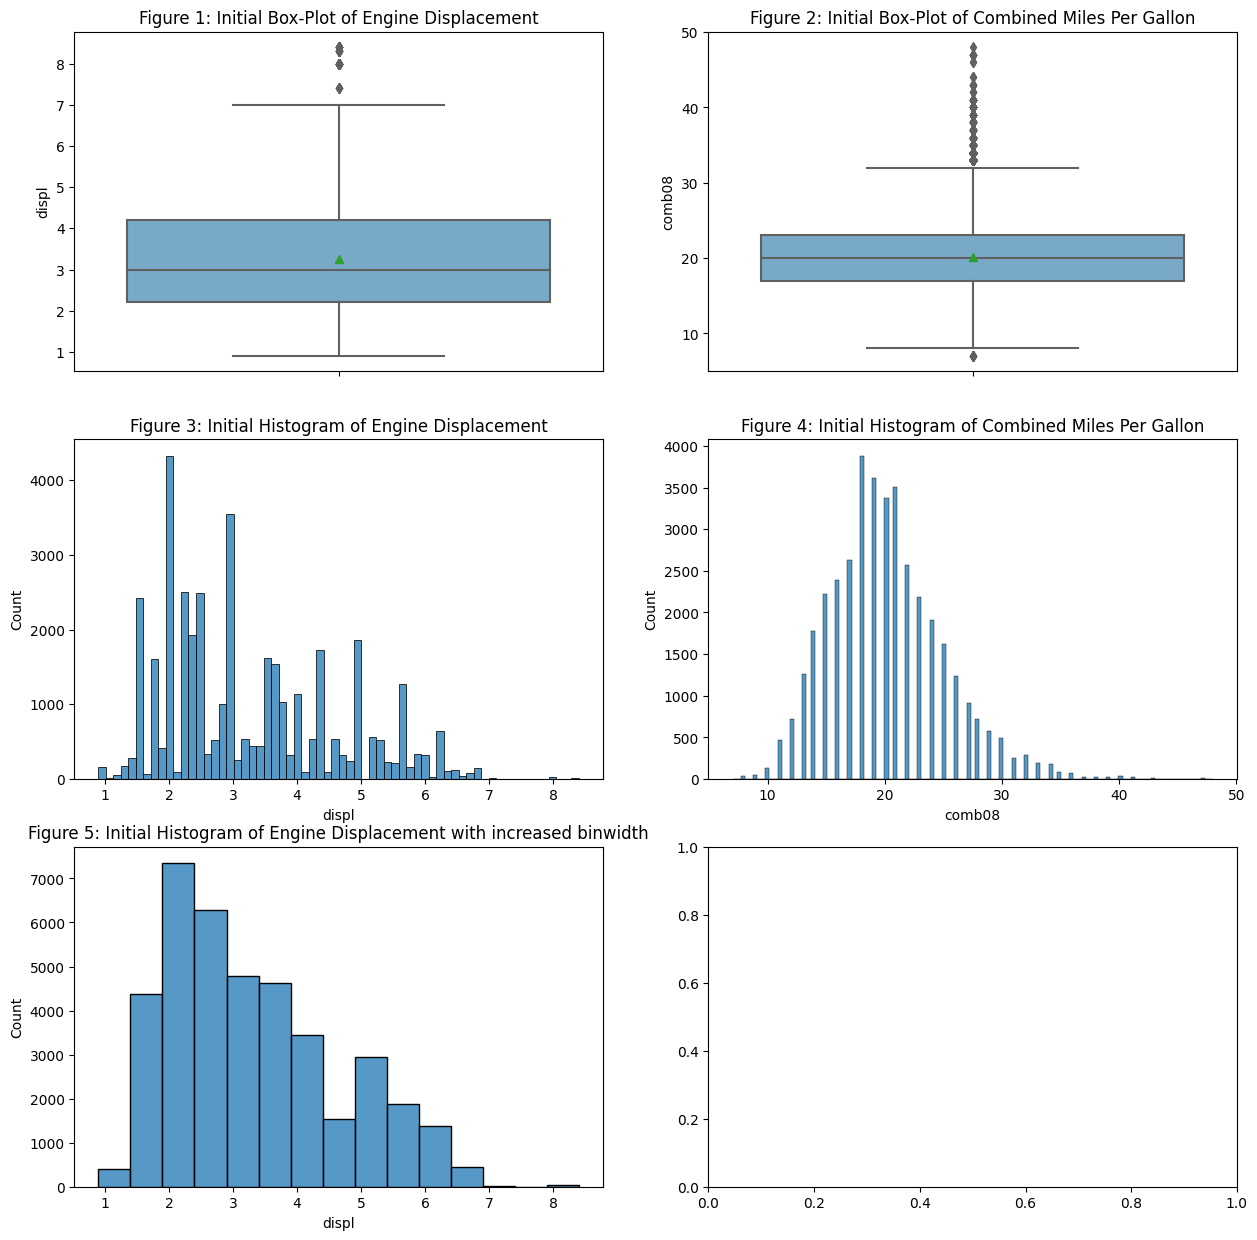

In [ ]:
#Box plots and Frequency distributions of 'displ' and 'comb08'
fig, axes = plt.subplots(3, 2, figsize=(15, 15))
ax1 = sns.boxplot(ax=axes[0][0],y = 'displ', data = data2, palette = 'Blues', showmeans = True,)
ax1.set_title("Figure 1: Initial Box-Plot of Engine Displacement")
ax2 = sns.boxplot(ax=axes[0][1],y = 'comb08', data = data2, palette = 'Blues', showmeans = True,)
ax2.set_title("Figure 2: Initial Box-Plot of Combined Miles Per Gallon")
ax3 = sns.histplot(ax=axes[1][0],x = 'displ', data = data2, palette = 'Blues')
ax3.set_title("Figure 3: Initial Histogram of Engine Displacement")
ax4 = sns.histplot(ax=axes[1][1],x = 'comb08', data = data2, palette = 'Blues')
ax4.set_title("Figure 4: Initial Histogram of Combined Miles Per Gallon")
ax5 = sns.histplot(ax=axes[2][0],x = 'displ', data = data2, binwidth = 0.5,palette = 'Blues')
ax5.set_title("Figure 5: Initial Histogram of Engine Displacement with increased binwidth")

As numerical analysis suggested, the frequency distributions of both variables are relativly normal, with only a slight positive skew.

The average engine displacement in litres is 3.26 with maximum value of 8.4 and minimum of 0.9. 50% of cars have a displacement greater than 3 litres and 25% greater than 4.2. The standard deviation is 1.34 and kurtosis is very low at -0.4 (normal dist = 3) meaning it has very 'thin' tails and very few outliers.

The average miles per gallon achived by a car is 20.15 with a maximum value of 48 miles and minimum of 7. 50% of cars can travel more than 20 miles per gallon while 25% can travel more than 23. Standard deviation is 4.89 and kurtosis is slightly higher than 'disp' but still very low at 0.94.

Figure 5 shows a clear negative relationshop between Engine Displacemnt and MPG. However, the "lowless" locally smoothed regression curve fit to the data suggests that this relationship becomes less negative around the 3 litre mark as the curve flattens out. This may indicate that Linear models may not be the best fit to the data. Additionally, the data seems to be relativley homoskedacitc but this can be examined closer later.

#### Categorical Analysis

Text(0, 0.5, 'Combined MPG')

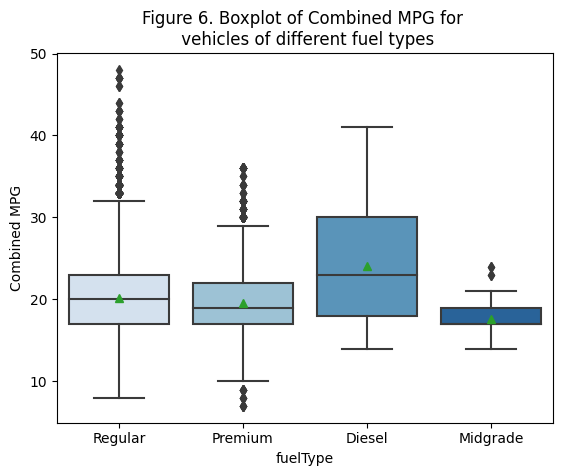

In [ ]:
ax = sns.boxplot(x='fuelType', y='comb08', data=data2, palette='Blues', showmeans = True)
ax.set_title("Figure 6. Boxplot of Combined MPG for \n vehicles of different fuel types")
ax.set_ylabel("Combined MPG")

Text(0.5, 1.0, 'Figure 8. Boxplot of Combined MPG for startStop')

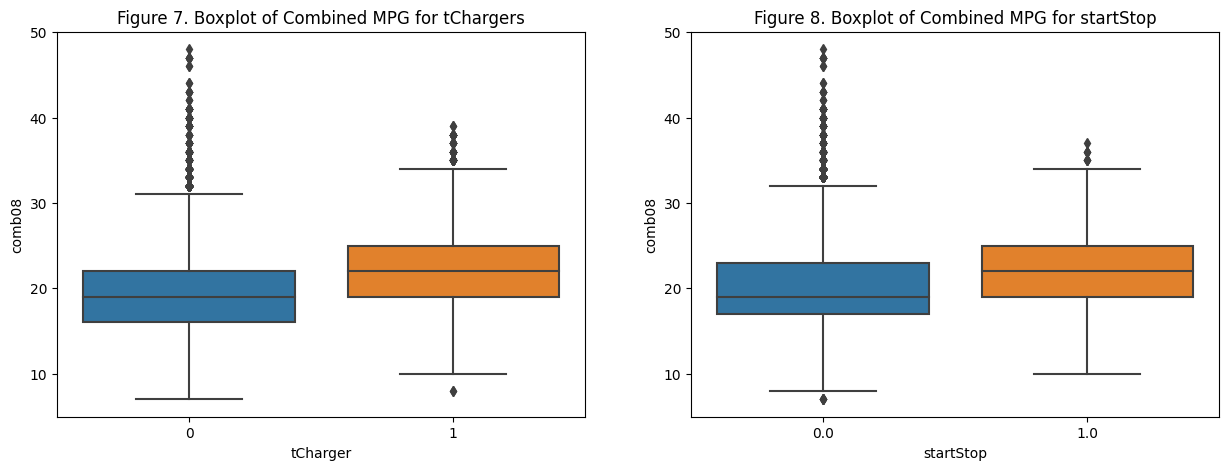

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
ax1 = sns.boxplot(ax=axes[0], x='tCharger',y='comb08',data=data2)
ax1.set_title("Figure 7. Boxplot of Combined MPG for tChargers")
ax3 = sns.boxplot(ax=axes[1], x='startStop',y='comb08',data=data2)
ax3.set_title("Figure 8. Boxplot of Combined MPG for startStop")

### Question 2: Analyse the relationship between MPG and displacement and test the significance of this relationship using an SLR.

#### Perform SLR on comb08 ~ displ

In [ ]:
# ================================================================================
# QUESTION 2: Analyse the relationship between MPG and displacement and test the significance of this relationship using an SLR.
# ================================================================================

reg = smf.ols(formula='comb08 ~ displ', data=data2).fit(cov_type='HC0')
print(reg.summary()) #Data is similar (Covariance type effects Std err and t-stat)

                            OLS Regression Results                            
Dep. Variable:                 comb08   R-squared:                       0.585
Model:                            OLS   Adj. R-squared:                  0.585
Method:                 Least Squares   F-statistic:                 4.091e+04
Date:                Wed, 31 May 2023   Prob (F-statistic):               0.00
Time:                        03:43:57   Log-Likelihood:            -1.0151e+05
No. Observations:               39536   AIC:                         2.030e+05
Df Residuals:                   39534   BIC:                         2.030e+05
Df Model:                           1                                         
Covariance Type:                  HC0                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     29.2333      0.052    566.945      0.0

In [ ]:
SER = np.sqrt(reg.mse_resid)
SER

3.1535969836540834

Text(0.5, 0, 'Engine Displacement (Litres)')

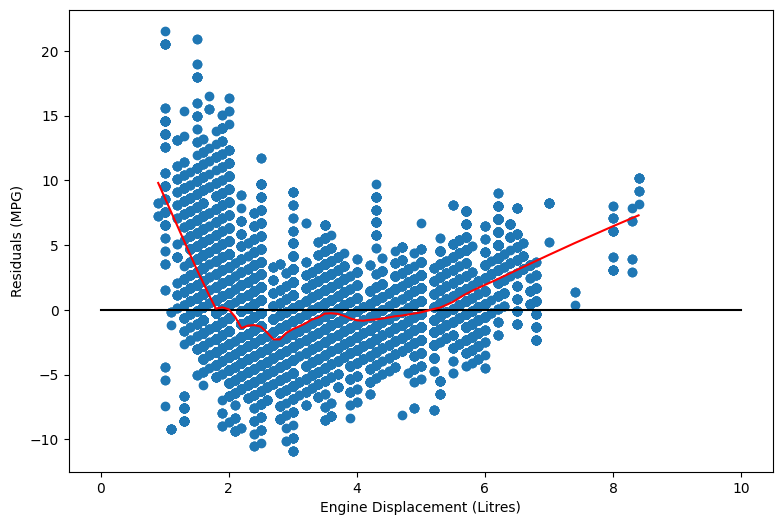

In [ ]:
resid = reg.resid
fit = reg.fittedvalues
fig = plt.figure(figsize=(20,6))
ax1 = fig.add_subplot(1,2,1)
x = np.linspace(0,10,100)
y = 0*x
ax1.plot(x, y,color='black');
ax1.scatter(data2['displ'], resid)
lowess = sm.nonparametric.lowess
z1 = lowess(resid, data2['displ'], frac=1./5)
ax1.plot(z1[:,0],z1[:,1],'red')
ax1.set_ylabel('Residuals (MPG)')
ax1.set_xlabel('Engine Displacement (Litres)')
#ax1.set_title('Figure 9. Scatter plot of residuals (MPG) against Engine Displacement (Litres)')



Text(0.5, 0, 'Engine Displacement (Litres)')

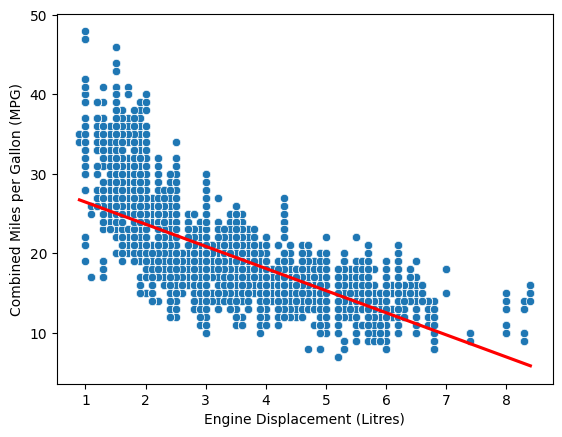

In [ ]:
ax2 = fig.add_subplot(1,2,2)
ax2 = sns.regplot(x = data2['displ'], y = data2['comb08'],color='red',scatter=False)
ax2 = sns.scatterplot(x = data2['displ'], y = data2['comb08'])
ax2.set_ylabel('Combined Miles per Gallon (MPG)')
ax2.set_xlabel('Engine Displacement (Litres)')
#ax2.set_title('Figure 10. Regression plot of Combined Miles per Gallon (MPG) against Engine Displacement (Litres)')

As Figure 10 demonstrates, it is safest to use heteroscedasticity robust standard errors as the residuals are definatly not homoscedastic.

The estimated relationship is $\hat{MPG} = 29.23 -2.79(Total Engine Displacemnet)$.

Thus, the effect of a 1 litre increase in engine displacemnet is a 2.79 mile decrease in miles per gallon.


#### Test Significance of Relationship

The hypotheses are: \\
$H_0: \beta_1 = 0$ \\
$H_1: \beta_1 \neq 0$ \\
$\alpha = 0.05$

In [ ]:
hypothesis = 'displ = 0'
t_test = reg.t_test(hypothesis)  # 2-sided t-test  H0: beta_1 = 0 (Predicting actual beta_1, NOT beta_1_hat)
print(t_test)

                             Test for Constraints                             
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
c0            -2.7861      0.014   -202.254      0.000      -2.813      -2.759


As the $P(z>202.254) = 0.000 < 0.05$ we can reject the null hypothisis that $\beta_1 = 0$ and conclude that there is a significant relationship between the displacemnet of an engine in litres and the miles achived per gallon (Assuming the following LSA's are met).

#### Discusssion of Assumptions and Strength of Fit

1. Linearity: 𝑌 = 𝛽0 + 𝛽1𝑋 + 𝜖 is the true population model
2. Exogeneity: 𝐸(𝜖|𝑋) = 0
3. Independence: 𝑌 , 𝑋 are i.i.d 𝑖𝑖
4. 4𝑡h moment exists: 𝐸(𝑌4) and 𝐸(𝑋4) are finite (< ∞)
5. Constant error variance: 𝑉𝑎𝑟(𝜖|𝑋) = 𝜎2

LSA 1 assumes that a linear line makes sense with our data. Whilst it is clear that the relationship bewteen MPG and engine displacement is always negative, the "lowless" locally smoothed regression curve fit to the data in Figure 5, suggests that this relationship becomes less negative around the 3 litre mark as the curve flattens out indicating that the true population model may not be linear. Thus, it is safest to state that LSA1 does not hold.

LSA 2 assumes that the expected value of residuals given X are 0 for all X. Again as the black locally smothed cureve fit to the residial plot in figure 6 shows, 𝐸(𝜖|𝑋) is only aproximatrly 0 between 2 litres and 6 litres and is positive before and after this interval. Whilst we could just atrribute this to end effects, the frequency distribution of engine displacement shows a significant proportion of our data points are between 1.5 and 2.5 litres so we must take this seriously and assume that LSA 2 is not met. This may be caused by omited variable bias.

LSA 3 assumes that the data is independant and identically distributed. We can assume this to be true based on the radom sampling of the 'train' dataset.

LSA 4 assumes that both X and Y have finite fourth moments i.e outliers are rare. Both variable units (distance and volume) are bounded from below by 0 and can be argued that they are bounded from above as you cannot travel infinte miles per gallon on earth while the laws of physics apply, this also applies to having infinite engine displacment. Additionally, the very low kurtosis implies outliers are very rare. Thus, it is safe to assume LSA 4.

LSA 5 assumes constant error variance. It can be seen in figure 6 that this does not hold. Thus we cannot assume LSA 5.

As to whether this model is a strong fit we look to $R^2 = 0.585$. This indicates that 58.5% of the variance in MPG can be explained by variations in Engine Displacment. This is a moderate to strong fit.

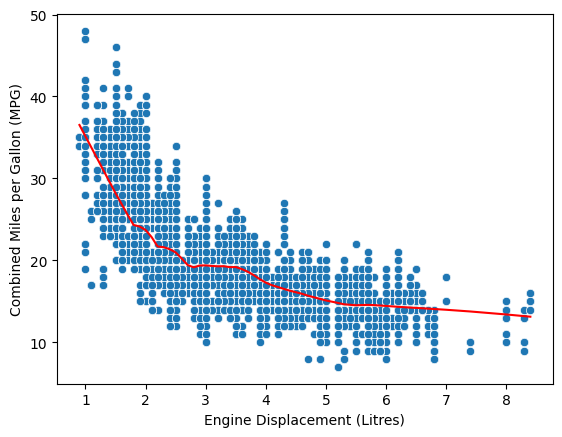

In [ ]:
lowess = sm.nonparametric.lowess
sns.scatterplot(x='displ',y='comb08',data=data2, palette = 'Blues')
z1 = lowess(data2['comb08'], data2['displ'], frac=1./5)
plt.plot(z1[:,0],z1[:,1],'red')
plt.xlabel('Engine Displacement (Litres)')
plt.ylabel('Combined Miles per Gallon (MPG)')
#plt.title("Figure 11: Scatter Plot of Engine Displacemnt vs MPG")
plt.show()

### Question 3:

#### Discuss which variables in the dataset could be causing omitted variable bias in your analysis in task 2, and justify clearly why you think that.

Potential Omitted Variables: barrels08, City08, Cylinders, Highway08, Ucity, Uhighway, Guzzler, co2TailpipeGpm, fescore, fuel type

We can examine, the correlation matrix below to get a better idea of variables causing bias.

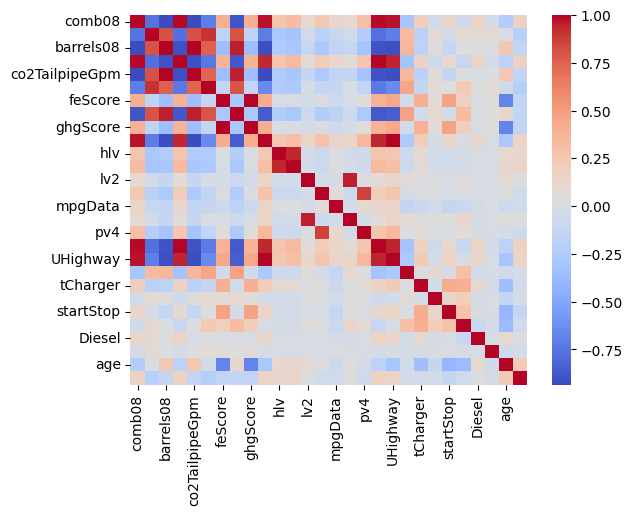

In [ ]:
corr_matrix = train.corr()
sns.heatmap(corr_matrix, cmap='coolwarm')
plt.show()

In [ ]:
corr_matrix.loc[['comb08']]

,comb08,displ,barrels08,city08,co2TailpipeGpm,cylinders,feScore,fuelCost08,ghgScore,highway08,...,UHighway,guzzler,tCharger,sCharger,startStop,Premium,Diesel,Midgrade,age,Manual
comb08,1.0,-0.764758,-0.929798,0.987677,-0.93335,-0.711973,0.404373,-0.889508,0.403001,0.973918,...,0.975325,-0.302259,0.193756,-0.05586,0.118069,-0.069343,0.138952,-0.027256,-0.225615,0.16598


In [ ]:
corr_matrix.loc[['displ']]

,comb08,displ,barrels08,city08,co2TailpipeGpm,cylinders,feScore,fuelCost08,ghgScore,highway08,...,UHighway,guzzler,tCharger,sCharger,startStop,Premium,Diesel,Midgrade,age,Manual
displ,-0.764758,1.0,0.808571,-0.777948,0.80468,0.901926,-0.164475,0.799816,-0.164058,-0.715143,...,-0.711223,0.341472,-0.20306,0.07631,-0.03333,0.105598,0.093019,0.08748,-0.00171,-0.211408


In order for a variable $Z$ to cause OVB in a regression, $Z$ must be a determinant of Y AND be correlated with $X_j$. We can examine each of the potential omitted variables outlined above to see if it is appropriate to include them in our regression.

'barrels08' is the annual petroleum consumption in barrels for fuelType1. As shown above, this is very strongly positively correlated with engine displacement at 0.81. This is no surprise as engines with higher displacement will consume more fuel. Additionally, it shows a stronger negative correlation with MPG than 'displ' with -0.93 and -0.76 respectivley. Thus, it is safe to assume 'barreles08' may be causing OVB.

'city08' and 'highway08' are the MPG acheived in the city and on the highway. Whilst they are both highly correlated with 'comb08' and 'displ', 'comb08' represents the combined MPG meaning it is a linear combination of 'city08' and 'highway08'. Thus, including these variables would lead to perfect colineararity and prevent us from isolating the effect of each variable $X_j$ seperatley as if $X_j$ is perfectly collinear with the other X's, we cannot change $X_j$ while holding the other X variables constant. The Same applies to 'ucity' and 'uhighway' as they are just the unadjusted values for 'city08' and 'highgway08'.

'Cylinders' shows the number of cylinders in the engine. Again this is strongly correlated with engine displacement as the number of cylinders in a car are a factor in determining the total displacement. However, this is not perfect colineararity as 'displ' = engine cylinder bore area $\times$ stroke of the crankshaft $\times$ 'cylinders'. Thus, 'displ' is not a linear combination of 'cylinders'. It is also strongly negativley correlated with 'comb08' at -0.71 and it makes sense that it is a determinant MPG. Thus, it may be causing OVB. Although, due to its high correlation with engine displacement, it will not give us much information over 'displ'.

'guzzler' is a catagorical variable that shows if a car is subject to the Gas Guzzler Tax. Whilst this sounds like it may be a determinant of MPG as a car subject to this tax would be inefficient or use alot of fuel it is not very correlated with MPG or engine displacement at -0.3 and 0.35 respectivley. Thus we will not assume it is causing OVB.

'co2TailpipeGpm' is tailpipe CO2 in grams/mile for fuelType1. Cars producing large amounts of CO2 are undergoing a larger proportion of incomplete combustion in the engine which is less efficient to complete combustion. Thus you would expect this variable to be a determinant of and highly negativley correlated with MPG. It is also strongley correlated with engine displacement at 0.81, thus we can assume that it is causing OVB.  

Fuel type is broken into three varaiables, 'premium','midgrade' and 'diesel'. It makes sense that these variables could be a determinant of MPG and they all show very low corrrelation displacement with all correlations $\leq 0.1, \geq -0.1$. Thus, they are more likley to give us information over and above engine displacement when included in our MLR.

Finally, 'fescore' is the EPA Fuel Economy Score from 1-10 where the higher the score the cleaner the emmisions. Whilst you would expect this to be correlated with MPG like the CO2 score it has a very low correlation with both MPG and engine displacement, thus we will not assume it causes OVB.

Variables to include in MLR:
 - Displ
 - barrels08
 - Cylinders
 - co2TailpipeGpm
 - premium
 - midgrade
 - diesel

However, it seems 'barrels08' and 'co2TailpipeGpm' are perfectly colinear with a correlation of 1. Thus, we will not include barrels08 as 'co2TailpipeGpm' is a more obvious determinant of MPG.

####  Include these omitted variables, together with displacement, in an MLR model, without any transformations or interactions or nonlinear effects; then fit the model.

In [ ]:
#Conduct MLR with variables possibly causing OVB
reg_mlr = smf.ols(formula='comb08 ~ displ + cylinders + Premium + Midgrade + Diesel + tCharger + Manual', data=train).fit(cov_type='HC0')
print(reg_mlr.summary())

                            OLS Regression Results                            
Dep. Variable:                 comb08   R-squared:                       0.635
Model:                            OLS   Adj. R-squared:                  0.635
Method:                 Least Squares   F-statistic:                     6371.
Date:                Wed, 31 May 2023   Prob (F-statistic):               0.00
Time:                        03:44:00   Log-Likelihood:                -79274.
No. Observations:               31628   AIC:                         1.586e+05
Df Residuals:                   31620   BIC:                         1.586e+05
Df Model:                           7                                         
Covariance Type:                  HC0                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     29.7927      0.072    416.331      0.0

In [ ]:
SER = np.sqrt(reg_mlr.mse_resid)
SER

2.9672459459336764

The SER of this model including variables causing OVB is 1.63 miles. The $R^2$ and $R_{adj}^2$ are the same at 88.9% whih is a strong fit.

#### Test for a relationship between MPG and displacement.

Again, the hypotheses are: \\
$H_0: \beta_{displ} = 0$ \\
$H_1: \beta_{displ} \neq 0$ \\
$\alpha = 0.05$

In [ ]:
hypothesis = 'displ = 0'
t_test = reg_mlr.t_test(hypothesis)
print(t_test)

                             Test for Constraints                             
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
c0            -2.5866      0.033    -79.193      0.000      -2.651      -2.523




```
# This is formatted as code
```

As the $P(z>15.011) = 0.000 < 0.05$ we can reject the null hypothisis that $\beta_{displ} = 0$ and conclude that there is a significant relationship between the displacement of an engine in litres and the miles achived per gallon (Assuming the following LSA's are met).

Note: $\hat{\beta_{displ}}$ has decreased significantly from -2.7861 to -0.4185. This change may indicate that OVB has been removed through the addition of the variables discussed above. However the two times increase in standard error from 0.014 to 0.028 may indicate that multicolineararity may still be present. We could try removing 'cylinders' from the regression as this is the most likley source of colinearity.

#### Discuss whether the assumptions of your test could hold for this data and whether and how well the data actually fits the model. Also discuss the level and sources of multi-collinearity present and whether you think this is problematic, or not, and why; and if so, problematic for what?

The assumptions of MLR are:
1. Linearity: $Y=\beta_0 + \beta_1 + \dots + \beta_p + \epsilon$ is the true population linear model.
2. Exogeneity: E(ε|X1, . . . , Xp) = 0

3. Independence: The data vectors $Y_i, X_{i,1}, . . . , X_{i,p}$ are i.i.d
(over i).
4. All 4th moments exist: $E(Y^4), E(X_j^4); j = 1, . . . , p$ exist, i.e.
are finite < ∞.
5. No perfect collinearity
6. Constant error variance.

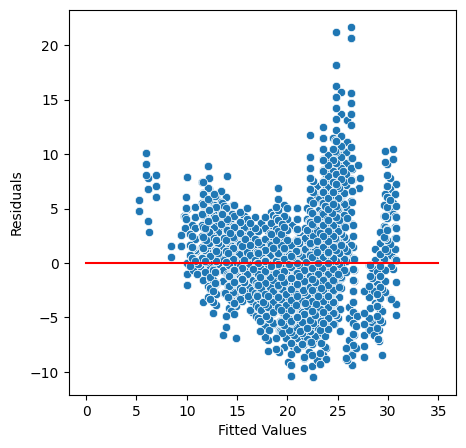

In [ ]:
resid_mlr = reg_mlr.resid
fit_mlr = reg_mlr.fittedvalues
fig, axes = plt.subplots(1, 1, figsize=(5, 5))
ax1 = sns.scatterplot(ax=axes,x=fit_mlr,y=resid_mlr)
ax1.set_ylabel('Residuals')
ax1.set_xlabel('Fitted Values')
#ax1.set_title('Figure 12. Plot of residuals vs Fitted Values')
x = np.linspace(0,1,1000)
y = 0*x
ax1.plot(35*x, y,'-r');


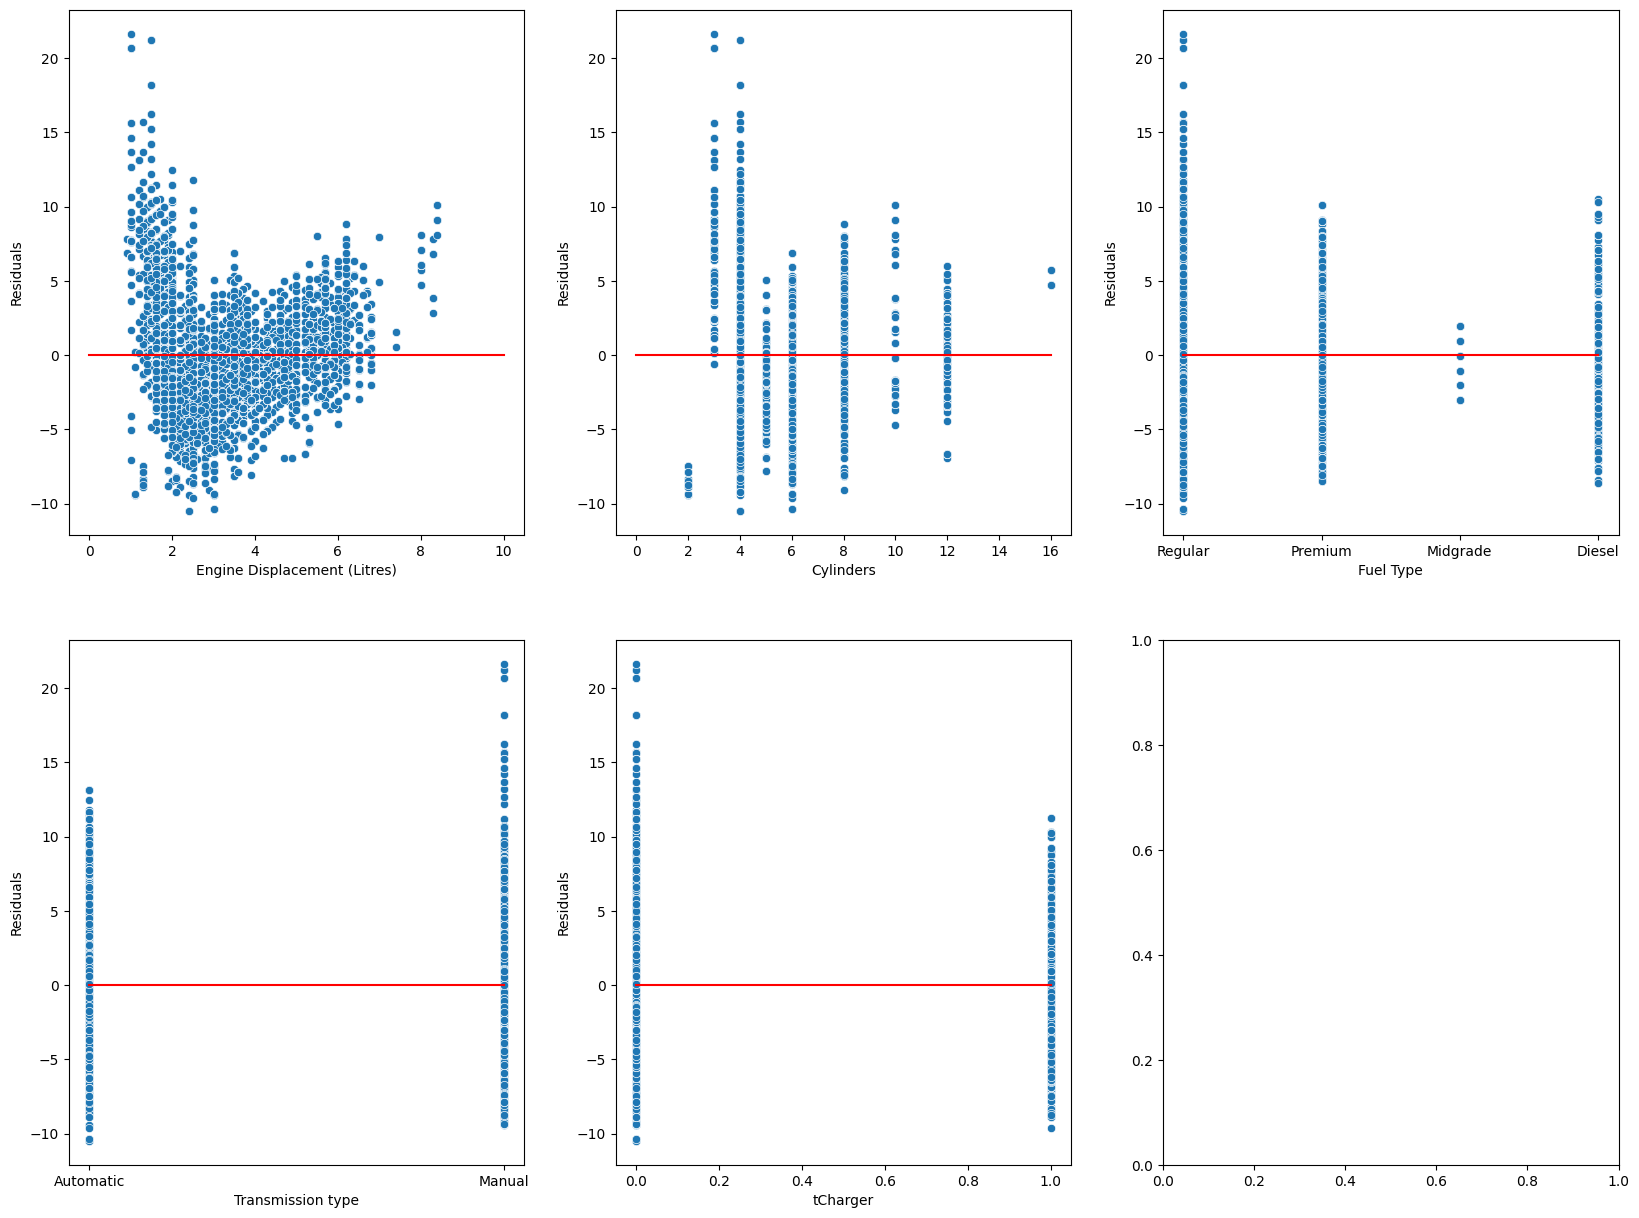

In [ ]:
fig, axes = plt.subplots(2, 3, figsize=(20, 15))
ax1 = sns.scatterplot(ax=axes[0,0], y=resid_mlr, x=train['displ'])
ax1.set_ylabel('Residuals')
ax1.set_xlabel('Engine Displacement (Litres)')
ax2 = sns.scatterplot(ax=axes[0,1], y=resid_mlr, x=train['cylinders'])
ax2.set_ylabel('Residuals')
ax2.set_xlabel('Cylinders')
ax3 = sns.scatterplot(ax=axes[0,2], y=resid_mlr, x=train['fuelType'])
ax3.set_ylabel('Residuals')
ax3.set_xlabel('Fuel Type')
ax4 = sns.scatterplot(ax=axes[1,0], y=resid_mlr, x=train['trany'])
ax4.set_ylabel('Residuals')
ax4.set_xlabel('Transmission type')
ax5 = sns.scatterplot(ax=axes[1,1], y=resid_mlr, x=train['tCharger'])
ax5.set_ylabel('Residuals')
ax5.set_xlabel('tCharger')
x = np.linspace(0,1,1000)
y = 0*x
ax1.plot(10*x, y,'-r')
ax2.plot(16*x, y,'-r')
ax3.plot(3*x, y,'-r')
ax4.plot(x, y,'-r')
ax5.plot(x, y,'-r')
# ax1.set_title('Figure 13. Plot of residuals vs Engine Displacement (Litres)')
# ax2.set_title('Figure 14. Plot of residuals vs Cylinders')
# ax3.set_title('Figure 15. Plot of residuals vs Fuel Type')
# ax4.set_title('Figure 16. Plot of residuals vs Transmission')
# ax5.set_title('Figure 17. Plot of residuals vs Turbocharging')
#plt.title("Plot of residuals vs fitted values")
plt.show()

When a linear regression model is suitable for a data set, the residuals should be randomly distributed around the zero line when plotted against fitted values. figure 9. shows that this is not the case as a distinct pattern is formed. This indicates that a linear model might not be the best fit for our data and we shoud assume that assumption 1 is not met.

Figures 10 through 14 show plots of residuals against each X variable in our MLR. In order for assumption 2 to hold the expected value of epsilon should be 0 for each value of X. This is clearly not the case so we conclude assumption 2 is not met.

As discussed eairlier we can assume data to be i.i.d. based on the random sampling of our train data set.


In [ ]:
print(stats.kurtosis(data2['co2TailpipeGpm']))
print(stats.kurtosis(data2['displ']))

1.7473106559003009
-0.39901433354429106


Assumption 4 relies on all variables having a finite fourth moment. Both engine displacement and co2emissions have kurtosis below that expected of a normal distribution so we can assume outliers are rare and both have finite fourth moments. All three fuel types are bounded from below by 0 and above by 1 so must have a finite fourth moment. Thus we can conclude assumption 4 holds.




In [ ]:
train.cylinders.replace([np.nan],[-1],inplace = True) # only two obs in this group
from statsmodels.stats.outliers_influence import variance_inflation_factor

features = train[['displ','cylinders','Midgrade','Premium','Diesel','tCharger','Manual']]
features = sm.add_constant(features)  # make sure to include a column of 1s when using the variance inflation factor function.

vif = []
for i in range(7):
    vif.append(variance_inflation_factor(features.values, i+1))

i=0
for var in ['displ','cylinders','Midgrade','Premium','Diesel','tCharger','Manual']:
  print(f'{var}: {vif[i]}')
  i+=1
print(sum(vif)/7)
train.cylinders.replace([-1],[np.nan],inplace = True)

displ: 5.927222862497122
cylinders: 6.027054350497147
Midgrade: 1.0114473744793637
Premium: 1.4121763727344965
Diesel: 1.0756499218129005
tCharger: 1.3518275351464437
Manual: 1.0626808423044183
2.5525798942102704


Assumption 5 was discussed earlier in regards to selection of variables to include in MLR and the removal of 'cylinders'. There should be very minimal multi-colinearity in our current model as all variables with perfect colinearity were removed. Variance Inflation factors calculated above show all variables have are below 5 and the average is below 2 so colinearity is not a huge issue. However, this seems to be the least of our concerns as assumption 1 and 2 have both been violated.

Assumption 6 is also clearly violated as we can see in Figures 10-14 as the variance changes along the X axis however, a HC0 robust regression has been used to take this into account.

In [ ]:
# ================================================================================
# QUESTION 3: Analyse the relationship between MPG and displacement and test the significance of this relationship using an SLR.
# ================================================================================

#OVB is a result of a correlation between the model X-variables and the error terms (failure of LSA 2)
#Estimated beta-j is biased in predicting Y. Omitted variable, Z, is a determinant of Y AND is correlated with X-j

data2.corr()

,comb08,displ,barrels08,city08,co2TailpipeGpm,cylinders,feScore,fuelCost08,ghgScore,highway08,...,UHighway,guzzler,tCharger,sCharger,startStop,Premium,Diesel,Midgrade,age,Manual
comb08,1.000000,-0.764708,-0.929635,0.987639,-0.933230,-0.711318,0.400999,-0.889380,0.399503,0.973829,...,0.975268,-0.304456,0.191216,-0.056173,0.119391,-0.070623,0.140784,-0.027095,-0.222662,0.166794
displ,-0.764708,1.000000,0.809351,-0.777454,0.805518,0.901373,-0.161057,0.800895,-0.160623,-0.714739,...,-0.711014,0.345880,-0.199503,0.076779,-0.034673,0.106642,0.092005,0.087996,-0.004694,-0.213092
barrels08,-0.929635,0.809351,1.000000,-0.906598,0.999075,0.751085,-0.354659,0.948764,-0.354839,-0.924169,...,-0.917562,0.366464,-0.181370,0.040991,-0.131366,0.023459,0.011957,0.017680,0.247193,-0.139046
city08,0.987639,-0.777454,-0.906598,1.000000,-0.911197,-0.733863,0.380246,-0.881354,0.378754,0.937139,...,0.940692,-0.317997,0.170604,-0.067831,0.103782,-0.113711,0.153958,-0.032686,-0.178627,0.171218
co2TailpipeGpm,-0.933230,0.805518,0.999075,-0.911197,1.000000,0.749322,-0.356310,0.947760,-0.356215,-0.927685,...,-0.921125,0.367738,-0.185015,0.041635,-0.133450,0.026084,-0.019857,0.017956,0.245502,-0.139243
cylinders,-0.711318,0.901373,0.751085,-0.733863,0.749322,1.000000,-0.132297,0.790474,-0.131976,-0.646995,...,-0.645862,0.461793,-0.126738,0.082204,0.020497,0.233681,0.033634,0.064798,-0.058339,-0.217881
feScore,0.400999,-0.161057,-0.354659,0.380246,-0.356310,-0.132297,1.000000,-0.280001,0.999575,0.415918,...,0.444555,-0.051917,0.400511,0.060331,0.470232,0.189103,0.005639,0.050149,-0.679490,-0.146046
fuelCost08,-0.889380,0.800895,0.948764,-0.881354,0.947760,0.790474,-0.280001,1.000000,-0.279858,-0.861593,...,-0.857262,0.473351,-0.054989,0.107153,-0.046172,0.326538,0.003478,0.029318,0.119395,-0.147361
ghgScore,0.399503,-0.160623,-0.354839,0.378754,-0.356215,-0.131976,0.999575,-0.279858,1.000000,0.414416,...,0.442847,-0.051643,0.398132,0.060880,0.469544,0.191218,-0.005521,0.050474,-0.679872,-0.145717
highway08,0.973829,-0.714739,-0.924169,0.937139,-0.927685,-0.646995,0.415918,-0.861593,0.414416,1.000000,...,0.995355,-0.267128,0.216127,-0.034071,0.139249,0.000249,0.119371,-0.014143,-0.281112,0.153174


In [ ]:
#Potential OVB in: fueltype, barrels, cO2tailpipe, cylinders, fuelcost
#displ is the total volume of all cylinders (litres), so cylinders may be a linear combination of displ
#barrels & co2tailpipe appear to be perfectly collinear



In [ ]:
reg = smf.ols(formula='comb08 ~ displ + Premium + Diesel + Midgrade + co2TailpipeGpm', data=data2).fit(cov_type='HC0')
reg.summary() #Data is similar (Covariance type effects Std err and t-stat)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 comb08   R-squared:                       0.889
Model:                            OLS   Adj. R-squared:                  0.889
Method:                 Least Squares   F-statistic:                 2.349e+04
Date:                Wed, 31 May 2023   Prob (F-statistic):               0.00
Time:                        03:44:04   Log-Likelihood:                -75506.
No. Observations:               39536   AIC:                         1.510e+05
Df Residuals:                   39530   BIC:                         1.511e+05
Df Model:                           5                                         
Covariance Type:                  HC0                                         
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         38.1584      0.095    399.598      0.000      37.971      38.346
displ             -0.2494      0.017    -14.691      0.000      -0.283      -0.216
Premium           -0.2795      0.017    -16.158      0.000      -0.313      -0.246
Diesel             3.6535      0.072     50.494      0.000       3.512       3.795
Midgrade          -0.4737      0.040    -11.847      0.000      -0.552      -0.395
co2TailpipeGpm    -0.0367      0.000   -121.474      0.000      -0.037      -0.036
==============================================================================
Omnibus:                    24802.702   Durbin-Watson:                   1.252
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           333740.222
Skew:                           2.841   Prob(JB):                         0.00
Kurtosis:                      16.050   Cond. No.                     9.28e+03
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC0)
[2] The condition number is large, 9.28e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

# Question 4:

In [ ]:
# ================================================================================
# QUESTION 4: At least 4 DIFFERENT models to explain MPG
# ================================================================================

#Potential Models:
#1.Log-log model, log-linear, linear-log
#2.Interaction effect between displ & fuelType (effect on each other)
#3.Interaction between displ and co2tailpipe
#4.Polynomial Fit
#5.Spline




```
`# This is formatted as code`
```

#### Variable Selection

In [ ]:
#Variable selection through forward selection
#forward_selection model
def forward_selected(data, response, nominated = []):
    """Linear model designed by forward selection.

    Parameters:
    -----------
    data : pandas DataFrame with all possible predictors and response

    response: string, name of response column in data

    Returns:
    --------
    model: an "optimal" fitted statsmodels linear model
           with an intercept
           selected by forward selection
           evaluated by adjusted R-squared
    """
    remaining = set(data.columns)
    selected = nominated
    remaining.remove(response)
    remaining ^= set(selected)
    current_score, best_new_score = 0.0, 0.0
    if nominated:
        formula = "{} ~ {} + 1".format(response, ' + '.join(nominated))
        current_score= smf.ols(formula, data).fit().rsquared_adj
        best_new_score = current_score
        print("you nominated variable(s) %s, the adj_r2 is: %f" %(nominated, current_score))
    while remaining and current_score == best_new_score:
        scores_with_candidates = []
        for candidate in remaining:
            formula = "{} ~ {} + 1".format(response,
                                           ' + '.join(selected + [candidate]))
            score = smf.ols(formula, data).fit().rsquared_adj
            scores_with_candidates.append((score, candidate))
        scores_with_candidates.sort()
        best_new_score, best_candidate = scores_with_candidates.pop()
        if current_score < best_new_score:
            print("adding %s increases adj_r2 from %f to %f" %(best_candidate, current_score, best_new_score))
            remaining.remove(best_candidate)
            selected.append(best_candidate)
            current_score = best_new_score
    formula = "{} ~ {} + 1".format(response,
                                   ' + '.join(selected))
    model = smf.ols(formula, data).fit()
    print("final model is %s, with adj_r2 of %f" %(formula, model.rsquared_adj))
    return model

forward_selected(train[['age','displ','Premium','Midgrade','Diesel','comb08','tCharger','sCharger','startStop','Manual']],'comb08',nominated=['displ'])

you nominated variable(s) ['displ'], the adj_r2 is: 0.584841
adding age increases adj_r2 from 0.584841 to 0.636325
adding Diesel increases adj_r2 from 0.636325 to 0.691681
adding tCharger increases adj_r2 from 0.691681 to 0.699002
adding Manual increases adj_r2 from 0.699002 to 0.701888
adding Premium increases adj_r2 from 0.701888 to 0.702724
adding Midgrade increases adj_r2 from 0.702724 to 0.703232
adding startStop increases adj_r2 from 0.703232 to 0.703727
adding sCharger increases adj_r2 from 0.703727 to 0.704255
final model is comb08 ~ displ + age + Diesel + tCharger + Manual + Premium + Midgrade + startStop + sCharger + 1, with adj_r2 of 0.704255


In [ ]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

features = train[['age','displ','Premium','Midgrade','Diesel','tCharger','sCharger','startStop','Manual']]
features = sm.add_constant(features)  # make sure to include a column of 1s when using the variance inflation factor function.

vif = []
for i in range(9):
    vif.append(variance_inflation_factor(features.values, i+1))

i=0
for var in ['age','displ','Premium','Midgrade','Diesel','tCharger','sCharger','startStop','Manual']:
  print(f'{var}: {vif[i]}')
  i+=1
print(sum(vif)/9)

age: 1.4088038278489454
displ: 1.1891451387501408
Premium: 1.4541718033160844
Midgrade: 1.018431473452628
Diesel: 1.0812059664107432
tCharger: 1.605402836346132
sCharger: 1.0909425181317567
startStop: 1.3639443106525706
Manual: 1.1151193243788244
1.2585741332542026


#### Interaction Effects

In [ ]:
#Initialise interaction effect variables
train['Displ_Prem'] = train['displ'] * train['Premium']
train['Displ_Mid'] = train['displ'] * train['Midgrade']
train['Displ_Dies'] = train['displ'] * train['Diesel']
int_model = smf.ols(formula='comb08 ~ displ + Premium + Diesel + Midgrade + Displ_Prem + Displ_Mid + Displ_Dies', data=train)
int_reg = int_model.fit(cov_type='HC0')
print(int_reg.summary())

                            OLS Regression Results                            
Dep. Variable:                 comb08   R-squared:                       0.645
Model:                            OLS   Adj. R-squared:                  0.645
Method:                 Least Squares   F-statistic:                     6691.
Date:                Wed, 31 May 2023   Prob (F-statistic):               0.00
Time:                        03:44:06   Log-Likelihood:                -78805.
No. Observations:               31629   AIC:                         1.576e+05
Df Residuals:                   31621   BIC:                         1.577e+05
Df Model:                           7                                         
Covariance Type:                  HC0                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     30.1930      0.067    448.668      0.0

Test that the interaction effects between FuelType and Engine Displacement are both equal to 0:

The test hypotheses are:
$$H_0: \,\,  \beta_5=\beta_6=\beta_7 = 0$$  
$$H_1: \,\,  \text{at least one of } \beta_5,\beta_6,\beta_7 \neq 0  $$

Here ${\bf L}$ should be a matrix with dimension $3 \times 8$ as we are selecting 3 interaction effects for testing from a model of 8. variables (including the intercept).

\begin{align}
{\bf L} = (&0 \,\, 0 \,\, 0 \,\, 0 \,\, 0 \,\, 1 \,\, 0\, \,0\,\  \\
           &0 \,\, 0 \,\, 0 \,\, 0 \,\, 0 \,\, 0 \,\, 1\,\, 0\,\ \\
           &0 \,\, 0 \,\, 0 \,\, 0 \,\, 0 \,\, 0 \,\, 0\,\, 1\,)
\end{align}

In [ ]:
L1=[0,0,0,0,0,1,0,0]
L2=[0,0,0,0,0,0,1,0]
L3=[0,0,0,0,0,0,0,1]
L=[L1,L2,L3]
print(L)
int_reg.f_test(L)

[[0, 0, 0, 0, 0, 1, 0, 0], [0, 0, 0, 0, 0, 0, 1, 0], [0, 0, 0, 0, 0, 0, 0, 1]]


<class 'statsmodels.stats.contrast.ContrastResults'>
<F test: F=334.56013300678796, p=6.876771627016706e-214, df_denom=3.16e+04, df_num=3>

In [ ]:
hypotheses = '(Displ_Prem = 0), (Displ_Mid = 0), (Displ_Dies = 0)'
f_test = int_reg.f_test(hypotheses)
print(f_test)

<F test: F=334.56013300678796, p=6.876771627016706e-214, df_denom=3.16e+04, df_num=3>


With the chosen $\alpha=0.05$, the test statistic is $F_{stat} = 334.56$ which follows an $F_{3,n-8} = F_{3, 3.16e+04}$ distribution under the null hypothesis. As the p-value, $P(F_{3, 3.16e+04} > 334.56) = 6.88 \times 10^{-214} \approx 0$, we can reject the null and conclude that at the very least 1 interaction effect between fuel type and engine displacement on combined MPG is significantly different to 0. By the principle of marginality in accepting this alternate hypothesis, we must include all interaction effects, as well as each fuel type category and engine displacement.

In [ ]:
train['Displ_Manual'] = train['displ'] * train['Manual']
int_model = smf.ols(formula='comb08 ~ displ + Manual + Displ_Manual', data=train)
int_reg = int_model.fit(cov_type='HC0')
print(int_reg.summary())

                            OLS Regression Results                            
Dep. Variable:                 comb08   R-squared:                       0.590
Model:                            OLS   Adj. R-squared:                  0.590
Method:                 Least Squares   F-statistic:                 1.180e+04
Date:                Wed, 31 May 2023   Prob (F-statistic):               0.00
Time:                        03:44:06   Log-Likelihood:                -81085.
No. Observations:               31629   AIC:                         1.622e+05
Df Residuals:                   31625   BIC:                         1.622e+05
Df Model:                           3                                         
Covariance Type:                  HC0                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       28.6225      0.066    436.112   

#### Log Transformations

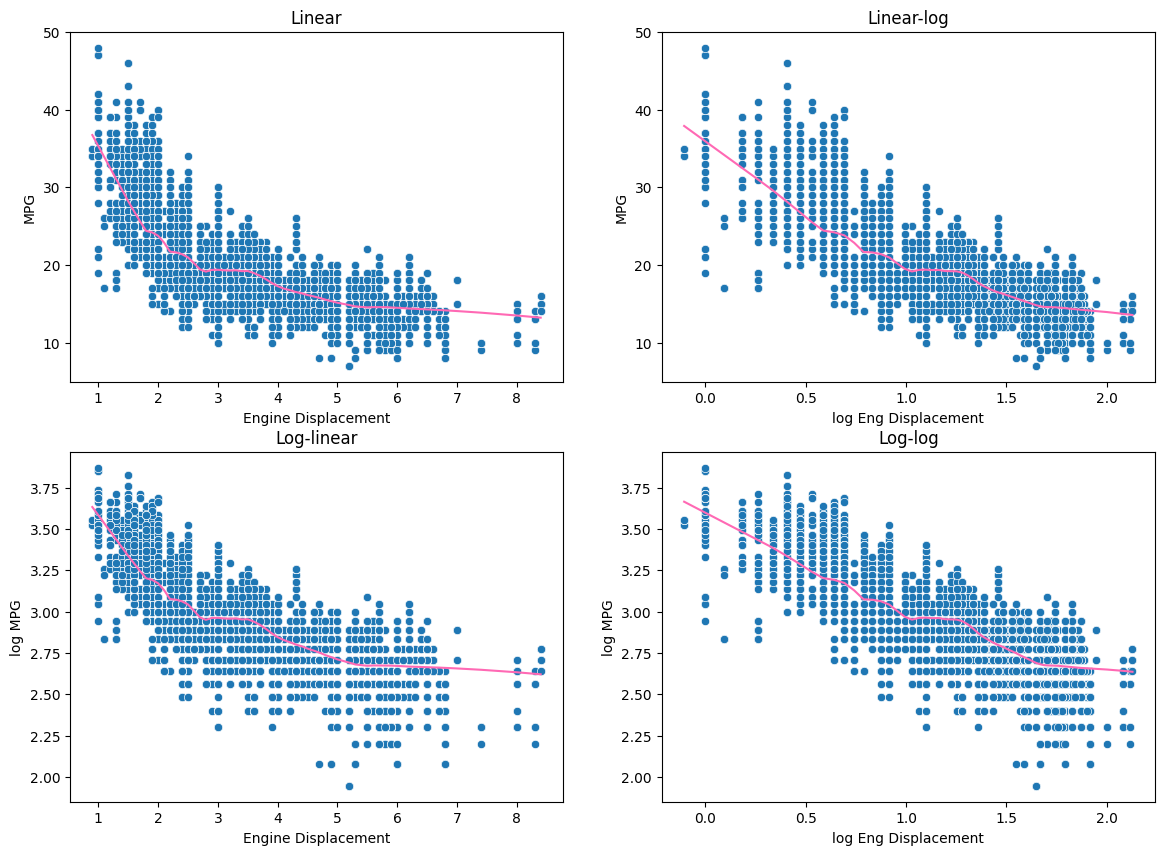

In [ ]:
#create log variables for mpg and displ
train['log_MPG'] = np.log(train['comb08'])
train['log_displ'] = np.log(train['displ'])

#plot linear-linear, linear-log, log-linear, log-log to find best fit to data
fig = plt.figure(figsize=(14,10))
ax1 = fig.add_subplot(2,2,1)
ax2 = fig.add_subplot(2,2,2)
ax3 = fig.add_subplot(2,2,3)
ax4 = fig.add_subplot(2,2,4)
ax1 = sns.scatterplot(ax=ax1,y=train['comb08'], x=train['displ'])
ax1.set(title='Linear', ylabel='MPG', xlabel='Engine Displacement')
ax2 = sns.scatterplot(ax=ax2,x=train['log_displ'], y=train['comb08'])
ax2.set(title='Linear-log', ylabel='MPG', xlabel='log Eng Displacement')
ax3 = sns.scatterplot(ax=ax3,x=train['displ'], y=train['log_MPG'])
ax3.set(title='Log-linear', ylabel='log MPG', xlabel='Engine Displacement')
ax4 = sns.scatterplot(ax=ax4,y=train['log_MPG'], x=train['log_displ'])
ax4.set(title='Log-log', ylabel='log MPG', xlabel='log Eng Displacement')

#plot lowless
lowess = sm.nonparametric.lowess
z1 = lowess(train['comb08'], train['displ'], frac=1./5)
ax1.plot(z1[:,0],z1[:,1],'hotpink')
z2 = lowess(train['comb08'], train['log_displ'], frac=1./5)
ax2.plot(z2[:,0],z2[:,1],'hotpink')
z3 = lowess(train['log_MPG'], train['displ'], frac=1./5)
ax3.plot(z3[:,0],z3[:,1],'hotpink')
z4 = lowess(train['log_MPG'], train['log_displ'], frac=1./5)
ax4.plot(z4[:,0],z4[:,1],'hotpink')
plt.show()


It seems the linear-log and log-log graphs give a more linear representation of the data compared to the linear plot. It is not clear at this stage which is beter. The log-linear model still shows a curve in the data.

In [ ]:
#Fit a regression to each plot then plot residuals vs fitted values to look for patterns
form1='comb08 ~ displ'
form2='comb08 ~ log_displ'
form3='log_MPG ~ displ'
form4='log_MPG ~ log_displ'
ols1 = smf.ols(formula=form1, data=train).fit()
print(ols1.summary())
resid1 = ols1.resid
fitted1 = ols1.fittedvalues
ols2 = smf.ols(formula=form2, data=train).fit()
print(ols2.summary())
resid2 = ols2.resid
fitted2 = ols2.fittedvalues
ols3 = smf.ols(formula=form3, data=train).fit()
print(ols3.summary())
resid3 = ols3.resid
fitted3 = ols3.fittedvalues
ols4 = smf.ols(formula=form4, data=train).fit()
print(ols4.summary())
resid4 = ols4.resid
fitted4 = ols4.fittedvalues


                            OLS Regression Results                            
Dep. Variable:                 comb08   R-squared:                       0.585
Model:                            OLS   Adj. R-squared:                  0.585
Method:                 Least Squares   F-statistic:                 4.456e+04
Date:                Wed, 31 May 2023   Prob (F-statistic):               0.00
Time:                        03:44:08   Log-Likelihood:                -81294.
No. Observations:               31629   AIC:                         1.626e+05
Df Residuals:                   31627   BIC:                         1.626e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     29.2626      0.047    626.443      0.0

In [ ]:
eres3 = np.exp(resid3)
eres4 = np.exp(resid4)
n = 31629
fp3 = sum(eres3)/n  #Duan Bias corrector (log-lin)
fp4 = sum(eres4)/n  #Duan Bias corrector (log-log)
fp31 = np.exp(ols3.mse_resid/2) #Normal Bias corrector (log-lin)
fp41 = np.exp(ols4.mse_resid/2) #Normal Bias corrector (log-log)

TS_lin = fitted1
TS_linlog = fitted2
TS_loglin = np.exp(fitted3)
TS_loglin3 = np.exp(fitted3) * fp3  #Multiplying Duan bias corrector for log-lin model
TS_loglin31 = np.exp(fitted3) * fp31 #Multiplying Normal bias corrector for log-lin model
TS_loglog = np.exp(fitted4)
TS_loglog4 = np.exp(fitted4) * fp4 #Multiplying Duan bias corrector for log-log model
TS_loglog41 = np.exp(fitted4) * fp41 #Multiplying Normal bias corrector for log-log model

In [ ]:
stats.describe(train['comb08']) #Retrieving variance of Ys

DescribeResult(nobs=31629, minmax=(7, 48), mean=20.144772202725346, variance=24.088721641701046, skewness=0.6799007594770043, kurtosis=0.9471536110135608)

In [ ]:
res_lin = train['comb08']-TS_lin #Residuals of linear model
#Calculating SER, R-squared, Adjusted R-squared
np.sqrt(sum(res_lin**2)/(n-2)), 1 - sum(res_lin**2)/((n-1)*24.088721641701046), 1 - sum(res_lin**2)/(n-2)/24.088721641701046

(3.162380077893385, 0.5848542023199852, 0.5848410760102599)

In [ ]:
res_linlog = train['comb08']-TS_linlog #Residuals of lin-log model
#Calculating SER, R-squared, Adjusted R-squared
np.sqrt(sum(res_linlog**2)/(n-2)), 1 - sum(res_linlog**2)/((n-1)*24.088721641701046), 1 - sum(res_linlog**2)/(n-2)/24.088721641701046

(2.910273868071508, 0.6484069880441252, 0.6483958711815725)

In [ ]:
res_loglin = train['comb08']-TS_loglin #Residuals of log-lin model (Uncorrected)
#Calculating SER, R-squared, Adjusted R-squared
np.sqrt(sum(res_loglin**2)/(n-2)), 1 - sum(res_loglin**2)/((n-1)*24.088721641701046), 1 - sum(res_loglin**2)/(n-2)/24.088721641701046

(3.0539358382614608, 0.6128383497863759, 0.612826108294922)

In [ ]:
res_loglin3 = train['comb08']-TS_loglin3 #Residuals of log-lin model (Duan)
#Calculating SER, R-squared, Adjusted R-squared
np.sqrt(sum(res_loglin3**2)/(n-2)), 1 - sum(res_loglin3**2)/((n-1)*24.088721641701046), 1 - sum(res_loglin3**2)/(n-2)/24.088721641701046

(3.0420272048905073, 0.6158518884348848, 0.6158397422271646)

In [ ]:
res_loglin31 = train['comb08']-TS_loglin31 #Residuals of log-lin model (Normal)
#Calculating SER, R-squared, Adjusted R-squared
np.sqrt(sum(res_loglin31**2)/(n-2)), 1 - sum(res_loglin31**2)/((n-1)*24.088721641701046), 1 - sum(res_loglin31**2)/(n-2)/24.088721641701046

(3.042042680373576, 0.615847979927618, 0.6158358335963166)

In [ ]:
res_loglog = train['comb08']-TS_loglog #Residuals of log-log model (Uncorrected)
#Calculating SER, R-squared, Adjusted R-squared
np.sqrt(sum(res_loglog**2)/(n-2)), 1 - sum(res_loglog**2)/((n-1)*24.088721641701046), 1 - sum(res_loglog**2)/(n-2)/24.088721641701046

(2.8610165239732024, 0.6602079234682465, 0.660197179734205)

In [ ]:
res_loglog4 = train['comb08']-TS_loglog4 #Residuals of log-log model (Duan)
#Calculating SER, R-squared, Adjusted R-squared
np.sqrt(sum(res_loglog4**2)/(n-2)), 1 - sum(res_loglog4**2)/((n-1)*24.088721641701046), 1 - sum(res_loglog4**2)/(n-2)/24.088721641701046

(2.8536149726343756, 0.6619637576591045, 0.6619530694420008)

In [ ]:
res_loglog41 = train['comb08']-TS_loglog41 #Residuals of log-log model (Normal)
#Calculating SER, R-squared, Adjusted R-squared
np.sqrt(sum(res_loglog41**2)/(n-2)), 1 - sum(res_loglog41**2)/((n-1)*24.088721641701046), 1 - sum(res_loglog41**2)/(n-2)/24.088721641701046

(2.853613438880588, 0.6619641210327429, 0.6619534328271286)

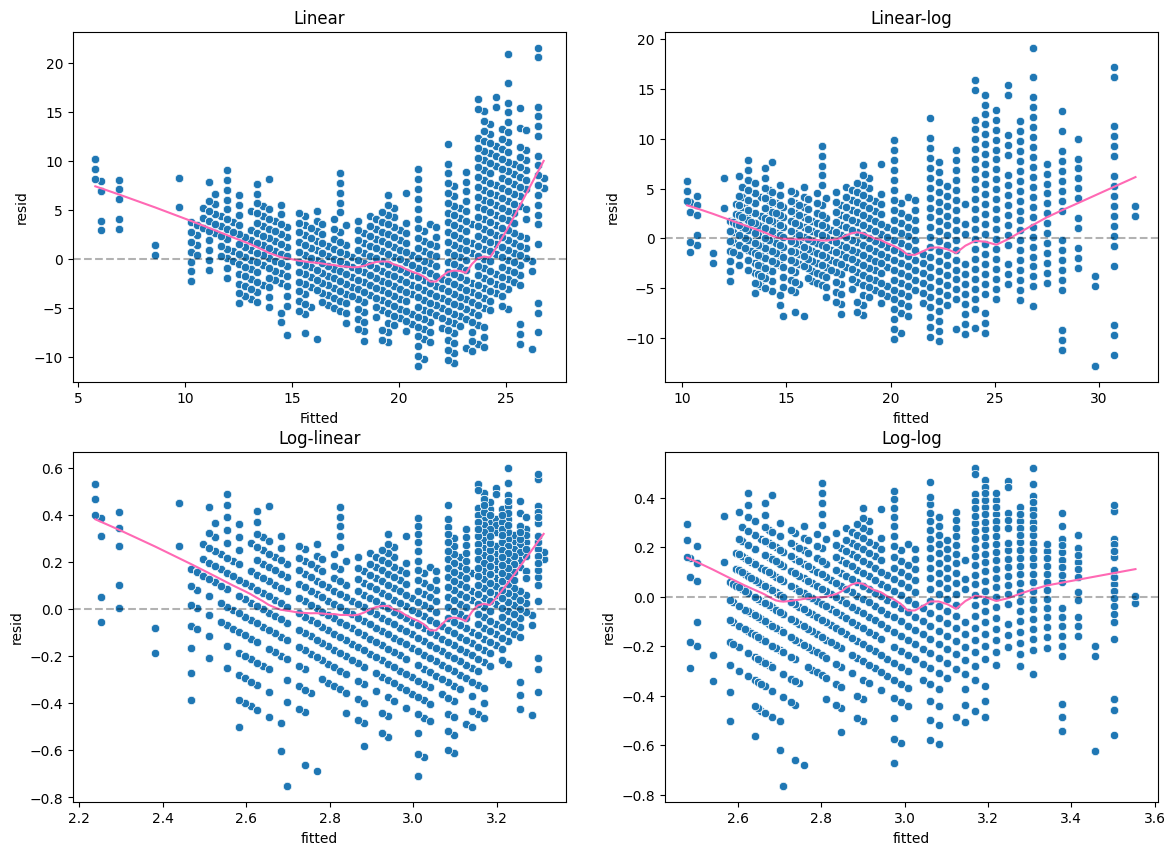

In [ ]:
#plot linear-linear, linear-log, log-linear, log-log fitted vs resid
fig = plt.figure(figsize=(14,10))
ax1 = fig.add_subplot(2,2,1)
ax2 = fig.add_subplot(2,2,2)
ax3 = fig.add_subplot(2,2,3)
ax4 = fig.add_subplot(2,2,4)
ax1 = sns.scatterplot(ax=ax1,y=resid1, x=fitted1)
ax1.set(title='Linear', ylabel='resid', xlabel='Fitted')
ax2 = sns.scatterplot(ax=ax2,x=fitted2, y=resid2)
ax2.set(title='Linear-log', ylabel='resid', xlabel='fitted')
ax3 = sns.scatterplot(ax=ax3,x=fitted3, y=resid3)
ax3.set(title='Log-linear', ylabel='resid', xlabel='fitted')
ax4 = sns.scatterplot(ax=ax4,y=resid4, x=fitted4)
ax4.set(title='Log-log', ylabel='resid', xlabel='fitted')

#plot lowless
lowess = sm.nonparametric.lowess
z1 = lowess(resid1, fitted1, frac=1./5)
ax1.plot(z1[:,0],z1[:,1],'hotpink')
z2 = lowess(resid2, fitted2, frac=1./5)
ax2.plot(z2[:,0],z2[:,1],'hotpink')
z3 = lowess(resid3, fitted3, frac=1./5)
ax3.plot(z3[:,0],z3[:,1],'hotpink')
z4 = lowess(resid4, fitted4, frac=1./5)
ax4.plot(z4[:,0],z4[:,1],'hotpink')

ax1.axhline(color='Black', alpha=0.3, linestyle='--')
ax2.axhline(color='Black', alpha=0.3, linestyle='--')
ax3.axhline(color='Black', alpha=0.3, linestyle='--')
ax4.axhline(color='Black', alpha=0.3, linestyle='--')
plt.show()

Plotting lowless locally smoothed line through plots of the respective residuals vs fited values shows a pattern still present in the log-linear model and a more random distribution around 0 of residuals in both the log-log and linear-log models. This inicates these models may be a better fit to the data as the first assumption of MLR can now be argued.

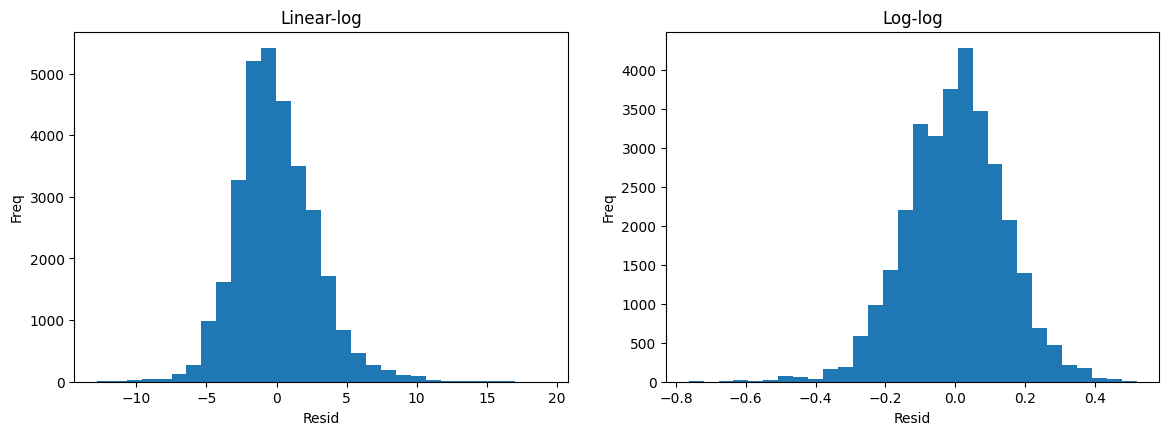

In [ ]:
#plot hist of residuals to determine which model's residuals are closest to normality
fig = plt.figure(figsize=(14,10))
ax1 = fig.add_subplot(2,2,1)
ax2 = fig.add_subplot(2,2,2)

ax1.hist(resid2, bins=30)
ax1.set(title='Linear-log', ylabel='Freq', xlabel='Resid')
ax2.hist(resid4, bins=30)
ax2.set(title='Log-log', ylabel='Freq', xlabel='Resid')
plt.show()

In [ ]:
print(f'linear-log skew: {stats.skew(resid2)}')
print(f'log-log skew: {stats.skew(resid4)}')

linear-log skew: 0.5387176123130529
log-log skew: -0.182438532410347


The log-log model his the most normal distribution of residuals with a skew of -0.18 compared to the linear-log model with skew of 0.54. It is likley the log-log model will be the best fit but we will compare the SER, $R^2$ and $R_{adj}^2$ to be sure.

In [ ]:
lin_log = smf.ols(formula='comb08 ~ log_displ', data=train).fit()
log_log = smf.ols(formula='log_MPG ~ log_displ', data=train).fit()
print(lin_log.summary())
print(log_log.summary())

                            OLS Regression Results                            
Dep. Variable:                 comb08   R-squared:                       0.648
Model:                            OLS   Adj. R-squared:                  0.648
Method:                 Least Squares   F-statistic:                 5.833e+04
Date:                Wed, 31 May 2023   Prob (F-statistic):               0.00
Time:                        03:44:11   Log-Likelihood:                -78666.
No. Observations:               31629   AIC:                         1.573e+05
Df Residuals:                   31627   BIC:                         1.574e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     30.7422      0.047    656.433      0.0

As predicted, the log-log model has a higher $R^2$ (66.2%) than the linear-log model (64.5%). However, as these are close it we should take into account the interpretability of each model.

In the case of a log-log model, a 1% change in X will result in a $\beta_1$% change in Y. Whereas with a linear_log model a 1% change in 𝑋 is associated with a $0.01\beta_1$ expected change in 𝑌. Which in the context of engine displacement and MPG will be easier to use as increasing engine displacemnet by a percentage will result in an expected increase in MPG in units Miles.

#### Splines

In [ ]:
#linear regression 1 knot
xi=train['displ'].median()
train['Step']=(train['displ']>xi)*(train['displ']-xi)

formula='comb08 ~ displ + Step'
spn_reg = smf.ols(formula=formula, data=train).fit()
resid1=spn_reg.resid
print(spn_reg.summary())

                            OLS Regression Results                            
Dep. Variable:                 comb08   R-squared:                       0.649
Model:                            OLS   Adj. R-squared:                  0.649
Method:                 Least Squares   F-statistic:                 2.924e+04
Date:                Wed, 31 May 2023   Prob (F-statistic):               0.00
Time:                        03:44:12   Log-Likelihood:                -78638.
No. Observations:               31629   AIC:                         1.573e+05
Df Residuals:                   31626   BIC:                         1.573e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     35.5064      0.093    383.211      0.0

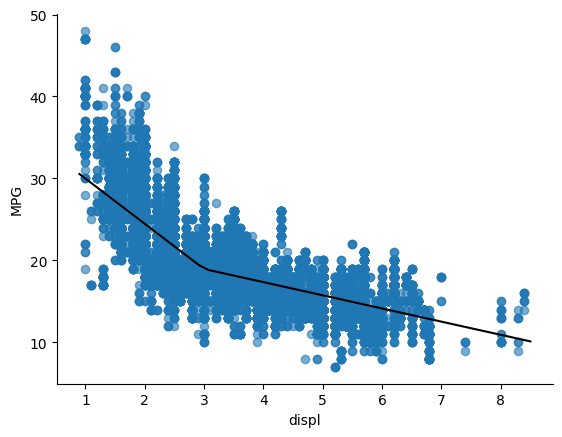

In [ ]:
fig, ax= plt.subplots()
sns.regplot(x=train['displ'],y=train['comb08'], ci=None, fit_reg=False, scatter_kws={'s': 35, 'alpha': 0.6})

a=train['displ'].min()
b=train['displ'].max()+0.1
x=np.linspace(a, b)

y=spn_reg.predict({'displ': x, 'Step': (x-xi)*((x>xi).astype(int))})
ax.plot(x, y, color='Black')

ax.set_xlabel('displ')
ax.set_ylabel('MPG')
#ax.set_title('Linear spline (1 knot)')

sns.despine()
plt.show()

In [ ]:
#linear regression 2 knots
xi1=train['displ'].quantile(.25)
xi2=train['displ'].quantile(.75)
train['Step1']=(train['displ']>xi1)*(train['displ']-xi1)
train['Step2']=(train['displ']>xi2)*(train['displ']-xi2)

formula='comb08 ~ displ + Step1 + Step2'
spn_reg2 = smf.ols(formula=formula, data=train).fit()
resid1=spn_reg.resid
print(spn_reg2.summary())

                            OLS Regression Results                            
Dep. Variable:                 comb08   R-squared:                       0.664
Model:                            OLS   Adj. R-squared:                  0.664
Method:                 Least Squares   F-statistic:                 2.082e+04
Date:                Wed, 31 May 2023   Prob (F-statistic):               0.00
Time:                        03:44:12   Log-Likelihood:                -77953.
No. Observations:               31629   AIC:                         1.559e+05
Df Residuals:                   31625   BIC:                         1.559e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     42.0086      0.181    232.494      0.0

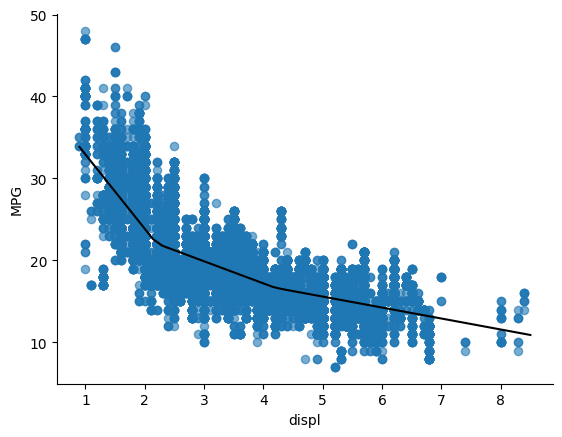

In [ ]:
fig, ax= plt.subplots()
sns.regplot(x=train['displ'],y=train['comb08'], ci=None, fit_reg=False, scatter_kws={'s': 35, 'alpha': 0.6})

a=train['displ'].min()
b=train['displ'].max()+0.1
x=np.linspace(a, b)

y=spn_reg2.predict({'displ': x, 'Step1': (x-xi1)*((x>xi1).astype(int)), 'Step2': (x-xi2)*((x>xi2).astype(int))})
ax.plot(x, y, color='Black')

ax.set_xlabel('displ')
ax.set_ylabel('MPG')
#ax.set_title('Linear spline (1 knot)')

sns.despine()
plt.show()

#### Optimum Model

In [ ]:
log_log = smf.ols(formula='log_MPG ~ log_displ', data=train).fit(cov_type='HC0')
print(log_log.summary())

                            OLS Regression Results                            
Dep. Variable:                log_MPG   R-squared:                       0.662
Model:                            OLS   Adj. R-squared:                  0.662
Method:                 Least Squares   F-statistic:                 4.938e+04
Date:                Wed, 31 May 2023   Prob (F-statistic):               0.00
Time:                        03:44:13   Log-Likelihood:                 17045.
No. Observations:               31629   AIC:                        -3.409e+04
Df Residuals:                   31627   BIC:                        -3.407e+04
Df Model:                           1                                         
Covariance Type:                  HC0                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      3.5031      0.002   1438.127      0.0

In [ ]:
log_log_all = smf.ols(formula='log_MPG ~ log_displ + age + startStop + sCharger + tCharger + Manual + Diesel + Premium + Midgrade', data=train).fit(cov_type='HC0')
resid_all = log_log_all.resid
fitted_all = log_log_all.fittedvalues
print(log_log_all.summary())
eres_all = np.exp(resid_all)
n = 31629
fpa = sum(eres_all)/n  #Duan Bias corrector (log-log all)
fpa1 = np.exp(log_log_all.mse_resid/2) #Normal Bias corrector (log-log all)

TS_loglogall = np.exp(fitted_all)
TS_loglogalld = np.exp(fitted_all) * fpa #Multiplying Duan bias corrector
TS_loglogalln = np.exp(fitted_all) * fpa1 #Multiplying normal bias corrector

                            OLS Regression Results                            
Dep. Variable:                log_MPG   R-squared:                       0.778
Model:                            OLS   Adj. R-squared:                  0.778
Method:                 Least Squares   F-statistic:                     9690.
Date:                Wed, 31 May 2023   Prob (F-statistic):               0.00
Time:                        03:44:13   Log-Likelihood:                 23721.
No. Observations:               31629   AIC:                        -4.742e+04
Df Residuals:                   31619   BIC:                        -4.734e+04
Df Model:                           9                                         
Covariance Type:                  HC0                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      3.6713      0.003   1314.328      0.0

In [ ]:
res_loglogall = train['comb08']-TS_loglogall #Residuals of log-log full model (uncorrected)
#Calculating SER, R squared, Adjusted R squared
np.sqrt(sum(res_loglogall**2)/(n-10)), 1 - sum(res_loglogall**2)/((n-1)*24.088721641701046), 1 - sum(res_loglogall**2)/(n-10)/24.088721641701046

(2.278093475346841, 0.7846198239079187, 0.7845585183136612)

In [ ]:
res_loglogalld = train['comb08']-TS_loglogalld #Residuals of log-log full model (Duan)
#Calculating SER, R squared, Adjusted R squared
np.sqrt(sum(res_loglogalld**2)/(n-10)), 1 - sum(res_loglogalld**2)/((n-1)*24.088721641701046), 1 - sum(res_loglogalld**2)/(n-10)/24.088721641701046

(2.2742497500062115, 0.7853460134538527, 0.7852849145614489)

In [ ]:
res_loglogalln = train['comb08']-TS_loglogalln #Residuals of log-log full model (Normal)
#Calculating SER, R squared, Adjusted R squared
np.sqrt(sum(res_loglogalln**2)/(n-10)), 1 - sum(res_loglogalln**2)/((n-1)*24.088721641701046), 1 - sum(res_loglogalln**2)/(n-10)/24.088721641701046

(2.274250569806556, 0.7853458587008895, 0.785284759764437)

In [ ]:
log_log_int = smf.ols(formula='log_MPG ~ log_displ + age + startStop + sCharger + tCharger + Manual + Displ_Manual + Diesel + Premium + Midgrade + Displ_Dies + Displ_Prem + Displ_Mid', data=train).fit(cov_type='HC0')
resid_int = log_log_int.resid
fitted_int = log_log_int.fittedvalues
print(log_log_int.summary())
eres_int = np.exp(resid_int)
n = 31629
fpi = sum(eres_int)/n  #Duan Bias corrector (log-log interactions)
fpi1 = np.exp(log_log_int.mse_resid/2) #Normal Bias corrector (log-log interactions)

TS_loglogint = np.exp(fitted_int)
TS_loglogintd = np.exp(fitted_int) * fpi #Multiplying Duan bias corrector
TS_loglogintn = np.exp(fitted_int) * fpi1 #Multiplying normal bias corrector

                            OLS Regression Results                            
Dep. Variable:                log_MPG   R-squared:                       0.781
Model:                            OLS   Adj. R-squared:                  0.781
Method:                 Least Squares   F-statistic:                     6884.
Date:                Wed, 31 May 2023   Prob (F-statistic):               0.00
Time:                        03:44:13   Log-Likelihood:                 23930.
No. Observations:               31629   AIC:                        -4.783e+04
Df Residuals:                   31615   BIC:                        -4.771e+04
Df Model:                          13                                         
Covariance Type:                  HC0                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        3.6707      0.003   1134.519   

In [ ]:
res_loglogint = train['comb08']-TS_loglogint #Residuals of log-log interactions model (uncorrected)
#Calculating SER, R squared, Adjusted R squared
np.sqrt(sum(res_loglogint**2)/(n-14)), 1 - sum(res_loglogint**2)/((n-1)*24.088721641701046), 1 - sum(res_loglogint**2)/(n-14)/24.088721641701046

(2.251205035132181, 0.7897007103234759, 0.7896142358409266)

In [ ]:
res_loglogintd = train['comb08']-TS_loglogintd #Residuals of log-log interactions model (Duan)
#Calculating SER, R squared, Adjusted R squared
np.sqrt(sum(res_loglogintd**2)/(n-14)), 1 - sum(res_loglogintd**2)/((n-1)*24.088721641701046), 1 - sum(res_loglogintd**2)/(n-14)/24.088721641701046

(2.2473088813100106, 0.7904280091149648, 0.7903418336956543)

In [ ]:
res_loglogintn = train['comb08']-TS_loglogintn #Residuals of log-log interactions model (Normal)
#Calculating SER, R squared, Adjusted R squared
np.sqrt(sum(res_loglogintn**2)/(n-14)), 1 - sum(res_loglogintn**2)/((n-1)*24.088721641701046), 1 - sum(res_loglogintn**2)/(n-14)/24.088721641701046

(2.247308338850035, 0.790428110288777, 0.7903419349110687)

In [ ]:
log_log_red = smf.ols(formula='log_MPG ~ log_displ + age + tCharger + Diesel', data=train).fit(cov_type='HC0')
resid_red = log_log_red.resid
fitted_red = log_log_red.fittedvalues
print(log_log_red.summary())
eres_red = np.exp(resid_red)
n = 31629
fpr = sum(eres_red)/n  #Duan Bias corrector (log-log reduced)
fpr1 = np.exp(log_log_red.mse_resid/2) #Normal Bias corrector (log-log reduced)

TS_loglogred = np.exp(fitted_red)
TS_loglogredd = np.exp(fitted_red) * fpr #Multiplying Duan bias corrector
TS_loglogredn = np.exp(fitted_red) * fpr1 #Multiplying Normal bias corrector

                            OLS Regression Results                            
Dep. Variable:                log_MPG   R-squared:                       0.775
Model:                            OLS   Adj. R-squared:                  0.775
Method:                 Least Squares   F-statistic:                 2.144e+04
Date:                Wed, 31 May 2023   Prob (F-statistic):               0.00
Time:                        03:44:14   Log-Likelihood:                 23506.
No. Observations:               31629   AIC:                        -4.700e+04
Df Residuals:                   31624   BIC:                        -4.696e+04
Df Model:                           4                                         
Covariance Type:                  HC0                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      3.6819      0.003   1372.485      0.0

In [ ]:
res_loglogred = train['comb08']-TS_loglogred #Residuals of log-log reduced model (Uncorrected)
#Calculating SER, R squared, Adjusted R squared
np.sqrt(sum(res_loglogred**2)/(n-5)), 1 - sum(res_loglogred**2)/((n-1)*24.088721641701046), 1 - sum(res_loglogred**2)/(n-5)/24.088721641701046

(2.29524990428861, 0.781328958231211, 0.7813012993592442)

In [ ]:
res_loglogredd = train['comb08']-TS_loglogredd #Residuals of log-log reduced model (Duan)
#Calculating SER, R squared, Adjusted R squared
np.sqrt(sum(res_loglogredd**2)/(n-5)), 1 - sum(res_loglogredd**2)/((n-1)*24.088721641701046), 1 - sum(res_loglogredd**2)/(n-5)/24.088721641701046

(2.291385988944298, 0.7820645776516967, 0.7820370118254447)

In [ ]:
res_loglogredn = train['comb08']-TS_loglogredn #Residuals of log-log reduced model (Normal)
#Calculating SER, R squared, Adjusted R squared
np.sqrt(sum(res_loglogredn**2)/(n-5)), 1 - sum(res_loglogredn**2)/((n-1)*24.088721641701046), 1 - sum(res_loglogredn**2)/(n-5)/24.088721641701046

(2.2913873395436615, 0.7820643207386049, 0.7820367548798569)

In [ ]:
xi=train['displ'].median()
train['Step']=(train['displ']>xi)*(train['displ']-xi)

formula='comb08 ~ displ + Step + age + tCharger + Diesel'
spn_reg = smf.ols(formula=formula, data=train).fit(cov_type='HC0')
resid1=spn_reg.resid
print(spn_reg.summary())

                            OLS Regression Results                            
Dep. Variable:                 comb08   R-squared:                       0.769
Model:                            OLS   Adj. R-squared:                  0.769
Method:                 Least Squares   F-statistic:                 1.723e+04
Date:                Wed, 31 May 2023   Prob (F-statistic):               0.00
Time:                        03:44:14   Log-Likelihood:                -72004.
No. Observations:               31629   AIC:                         1.440e+05
Df Residuals:                   31623   BIC:                         1.441e+05
Df Model:                           5                                         
Covariance Type:                  HC0                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     39.5458      0.120    329.631      0.0

In [ ]:
#Calculating SER, R squared, Adjusted R squared
np.sqrt(sum(resid1**2)/(n-7)), 1 - sum(resid1**2)/((n-1)*24.088721641701046), 1 - sum(resid1**2)/(n-7)/24.088721641701046

(2.357738892455174, 0.7692746751556147, 0.7692308970280748)

In [ ]:
#linear regression 2 knots
xi1=train['displ'].quantile(.25)
xi2=train['displ'].quantile(.75)
train['Step1']=(train['displ']>xi1)*(train['displ']-xi1)
train['Step2']=(train['displ']>xi2)*(train['displ']-xi2)

formula='comb08 ~ displ + Step1 + Step2 + age + tCharger + Diesel'
spn_reg2 = smf.ols(formula=formula, data=train).fit(cov_type='HC0')
resid2=spn_reg2.resid
print(spn_reg2.summary())

                            OLS Regression Results                            
Dep. Variable:                 comb08   R-squared:                       0.776
Model:                            OLS   Adj. R-squared:                  0.776
Method:                 Least Squares   F-statistic:                 1.513e+04
Date:                Wed, 31 May 2023   Prob (F-statistic):               0.00
Time:                        03:44:14   Log-Likelihood:                -71517.
No. Observations:               31629   AIC:                         1.430e+05
Df Residuals:                   31622   BIC:                         1.431e+05
Df Model:                           6                                         
Covariance Type:                  HC0                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     45.6137      0.256    178.514      0.0

In [ ]:
#Calculating SER, R squared, Adjusted R squared
np.sqrt(sum(resid2**2)/(n-7)), 1 - sum(resid2**2)/((n-1)*24.088721641701046), 1 - sum(resid2**2)/(n-7)/24.088721641701046

(2.321673077610549, 0.7762793967943249, 0.7762369477519103)

| Model      |   SER  | R-squared | R-squared adj. |
|------------|--------|-----------|----------------|
| Log-Log - All variables|2.274|0.785|0.785|
| Log-Log - All variables + Interactions|2.247|0.790|0.790|
| Log-Log - Reduced|2.291|0.782|0.782|
| Spline (Single) - Reduced|2.358|0.769|0.769|
| Spline (Double) - Reduced|2.322|0.776|0.776|

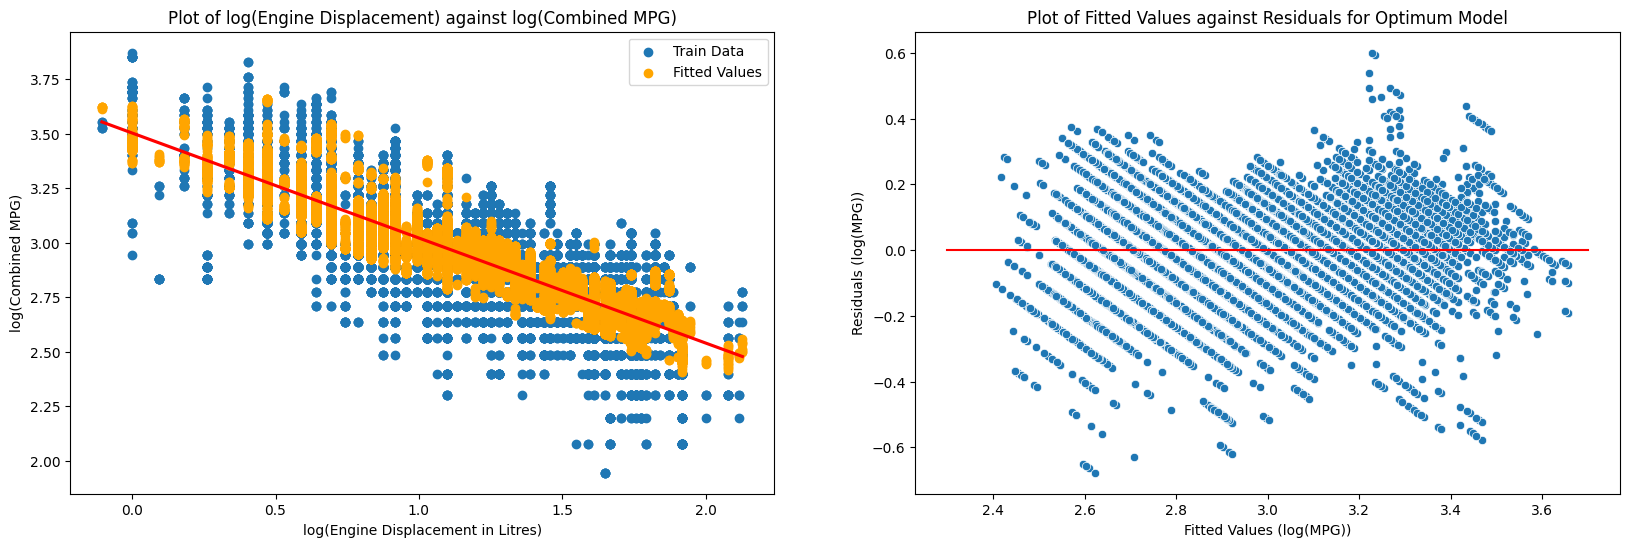

In [ ]:
fig = plt.figure(figsize=(20,6))
ax1 = fig.add_subplot(1,2,1)
ax1.scatter(x = train['log_displ'], y = train['log_MPG'])
ax1.scatter(x = train['log_displ'], y = fitted_red, color = 'orange')
ax1 = sns.regplot(x=train['log_displ'], y = fitted_red, color = 'red',scatter=False)
ax1.set_title('Plot of log(Engine Displacement) against log(Combined MPG)')
ax1.set_xlabel('log(Engine Displacement in Litres)')
ax1.set_ylabel('log(Combined MPG)')
ax1.legend(('Train Data','Fitted Values'),loc="upper right")
ax2 = fig.add_subplot(1,2,2)
ax2 = sns.scatterplot(x = fitted_red, y = resid_red)
ax2.set_title('Plot of Fitted Values against Residuals for Optimum Model')
ax2.set_xlabel('Fitted Values (log(MPG))')
ax2.set_ylabel('Residuals (log(MPG))')

x = np.linspace(0,1,1000)
y = 0*x
ax2.plot(1.4*x + 2.3, y,'-r')

### Parametric

In [ ]:
# variables=['testscr','avginc','expn_stu','el_pct','comp_stu','calw_pct','meal_pct']
# with sns.axes_style('white'):
#     g=sns.pairplot(data[variables], kind='reg',
#                    plot_kws={'scatter_kws' :{'color': sns.color_palette('Blues')[-1], 'alpha': 0.4}})

In [ ]:
## parametric 1

formula='comb08 ~ displ + np.power(displ, 2)'
ols_para1 = smf.ols(formula=formula, data=data2).fit()
resid_para1 = ols_para1.resid
fitted_para1 = ols_para1.fittedvalues
ols_para1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 comb08   R-squared:                       0.645
Model:                            OLS   Adj. R-squared:                  0.645
Method:                 Least Squares   F-statistic:                 3.598e+04
Date:                Wed, 31 May 2023   Prob (F-statistic):               0.00
Time:                        03:44:40   Log-Likelihood:                -98385.
No. Observations:               39536   AIC:                         1.968e+05
Df Residuals:                   39533   BIC:                         1.968e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept             36.7313      0.099    371.190      0.000      36.537      36.925
displ                 -7.4941      0.058   -128.602      0.000      -7.608      -7.380
np.power(displ, 2)     0.6315      0.008     82.246      0.000       0.616       0.647
==============================================================================
Omnibus:                     3104.114   Durbin-Watson:                   1.131
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             6918.413
Skew:                           0.504   Prob(JB):                         0.00
Kurtosis:                       4.784   Cond. No.                         128.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

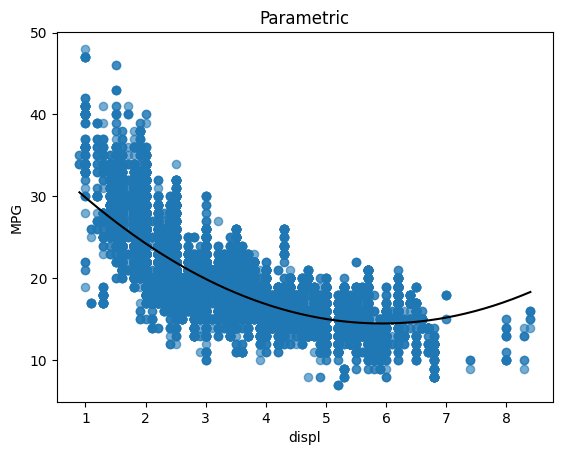

In [ ]:
fig, ax= plt.subplots()
sns.regplot(x=train['displ'],y=train['comb08'], ci=None, fit_reg=False, scatter_kws={'s': 35, 'alpha': 0.6})

a=train['displ'].min()
b=train['displ'].max()
x=np.linspace(a, b)

y=ols_para1.predict({'displ': x})
ax.plot(x, y, color='Black')

ax.set_xlabel('displ')
ax.set_ylabel('MPG')
ax.set_title('Parametric')


plt.show()

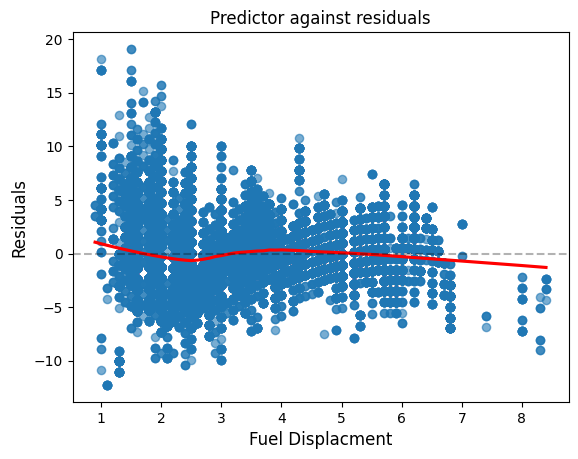

In [ ]:
para_residuals=ols_para1.resid

fig, ax= plt.subplots()
sns.regplot(x=data2['displ'], y=para_residuals, lowess=True, ax=ax, scatter_kws={'s': 35, 'alpha': .6}, line_kws={"color": "red"})
ax.set_xlabel('Fuel Displacment',  {'fontsize': 12})
ax.set_ylabel('Residuals', {'fontsize': 12})
ax.set_title('Predictor against residuals')
plt.axhline(color='Black', alpha=0.3, linestyle='--')
plt.show()

In [ ]:
## parametric 2

formula='comb08 ~ displ + np.power(displ, 2) + np.power(displ, 3)'
ols_para2 = smf.ols(formula=formula, data=data2).fit()
resid_para2 = ols_para2.resid
fitted_para2 = ols_para2.fittedvalues
ols_para2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 comb08   R-squared:                       0.656
Model:                            OLS   Adj. R-squared:                  0.656
Method:                 Least Squares   F-statistic:                 2.510e+04
Date:                Wed, 31 May 2023   Prob (F-statistic):               0.00
Time:                        03:45:10   Log-Likelihood:                -97802.
No. Observations:               39536   AIC:                         1.956e+05
Df Residuals:                   39532   BIC:                         1.956e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept             43.2948      0.214    201.928      0.000      42.875      43.715
displ                -13.6656      0.189    -72.495      0.000     -14.035     -13.296
np.power(displ, 2)     2.3583      0.051     46.420      0.000       2.259       2.458
np.power(displ, 3)    -0.1466      0.004    -34.373      0.000      -0.155      -0.138
==============================================================================
Omnibus:                     2761.551   Durbin-Watson:                   1.121
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             6190.933
Skew:                           0.452   Prob(JB):                         0.00
Kurtosis:                       4.715   Cond. No.                     1.73e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.73e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

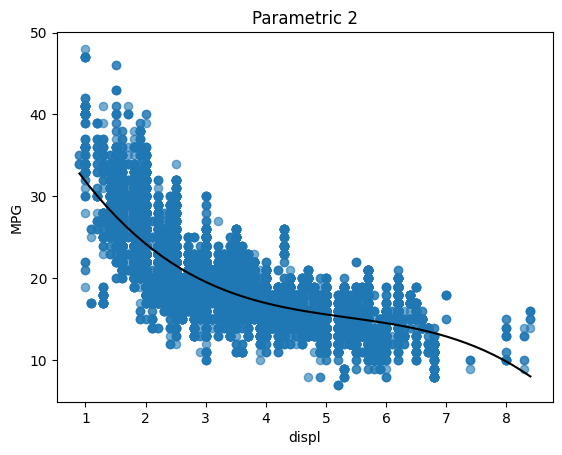

In [ ]:
fig, ax= plt.subplots()
sns.regplot(x=train['displ'],y=train['comb08'], ci=None, fit_reg=False, scatter_kws={'s': 35, 'alpha': 0.6})

a=train['displ'].min()
b=train['displ'].max()
x=np.linspace(a, b)

y=ols_para2.predict({'displ': x})
ax.plot(x, y, color='Black')

ax.set_xlabel('displ')
ax.set_ylabel('MPG')
ax.set_title('Parametric 2')


plt.show()

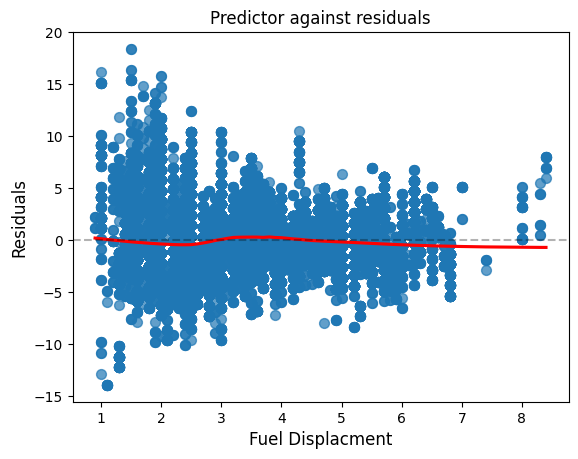

In [ ]:
para_residuals=ols_para2.resid

fig, ax= plt.subplots()
sns.regplot(x=data2['displ'], y=para_residuals, lowess=True, ax=ax, scatter_kws={'s': 50, 'alpha': .7}, line_kws={"color": "red"} )
ax.set_xlabel('Fuel Displacment',  {'fontsize': 12})
ax.set_ylabel('Residuals', {'fontsize': 12})
ax.set_title('Predictor against residuals')
plt.axhline(color='Black', alpha=0.3, linestyle='--')
plt.show()




In [ ]:
## parametric 3

formula='comb08 ~ displ + np.power(displ, 2) + np.power(displ, 3) + np.power(displ, 4)'
ols_para3 = smf.ols(formula=formula, data=data2).fit()
resid_para3 = ols_para3.resid
fitted_para3 = ols_para3.fittedvalues
ols_para3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 comb08   R-squared:                       0.661
Model:                            OLS   Adj. R-squared:                  0.661
Method:                 Least Squares   F-statistic:                 1.931e+04
Date:                Wed, 31 May 2023   Prob (F-statistic):               0.00
Time:                        03:45:20   Log-Likelihood:                -97469.
No. Observations:               39536   AIC:                         1.949e+05
Df Residuals:                   39531   BIC:                         1.950e+05
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept             53.0087      0.431    123.097      0.000      52.165      53.853
displ                -25.6739      0.499    -51.425      0.000     -26.652     -24.695
np.power(displ, 2)     7.3981      0.201     36.859      0.000       7.005       7.791
np.power(displ, 3)    -1.0058      0.033    -30.120      0.000      -1.071      -0.940
np.power(displ, 4)     0.0509      0.002     25.940      0.000       0.047       0.055
==============================================================================
Omnibus:                     2827.087   Durbin-Watson:                   1.115
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             7022.922
Skew:                           0.431   Prob(JB):                         0.00
Kurtosis:                       4.876   Cond. No.                     2.37e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.37e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

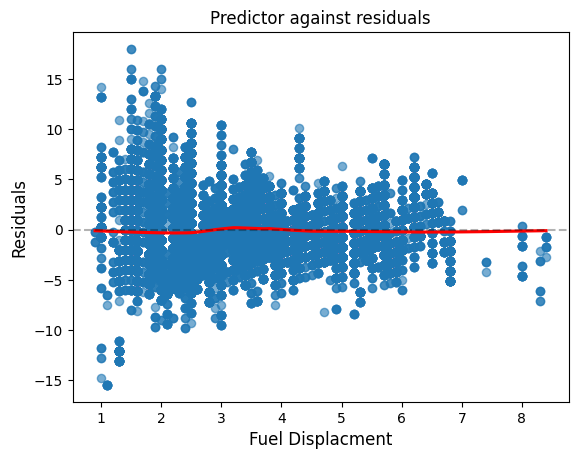

In [ ]:
para_residuals=ols_para3.resid

fig, ax= plt.subplots()
sns.regplot(x=data2['displ'], y=para_residuals, lowess=True, ax=ax, scatter_kws={'s': 35, 'alpha': .6}, line_kws={"color": "red"})
ax.set_xlabel('Fuel Displacment',  {'fontsize': 12})
ax.set_ylabel('Residuals', {'fontsize': 12})
ax.set_title('Predictor against residuals')
plt.axhline(color='Black', alpha=0.3, linestyle='--')
plt.show()

In [ ]:
formula='comb08 ~ displ + np.power(displ, 2) + np.power(displ, 3) + np.power(displ, 4) + age + tCharger + Diesel'
ols_para4 = smf.ols(formula=formula, data=train).fit()
resid_para = ols_para4.resid
fitted_para = ols_para4.fittedvalues
ols_para4.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 comb08   R-squared:                       0.782
Model:                            OLS   Adj. R-squared:                  0.782
Method:                 Least Squares   F-statistic:                 1.618e+04
Date:                Wed, 31 May 2023   Prob (F-statistic):               0.00
Time:                        03:45:26   Log-Likelihood:                -71126.
No. Observations:               31629   AIC:                         1.423e+05
Df Residuals:                   31621   BIC:                         1.423e+05
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept             59.7647      0.391    152.881      0.000      58.998      60.531
displ                -29.1925      0.454    -64.351      0.000     -30.082     -28.303
np.power(displ, 2)     8.5450      0.183     46.678      0.000       8.186       8.904
np.power(displ, 3)    -1.1560      0.031    -37.846      0.000      -1.216      -1.096
np.power(displ, 4)     0.0571      0.002     31.728      0.000       0.054       0.061
age                   -0.1360      0.001   -109.420      0.000      -0.138      -0.134
tCharger              -1.5206      0.037    -40.571      0.000      -1.594      -1.447
Diesel                 6.8620      0.079     86.775      0.000       6.707       7.017
==============================================================================
Omnibus:                     2044.142   Durbin-Watson:                   1.975
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             9034.921
Skew:                           0.142   Prob(JB):                         0.00
Kurtosis:                       5.603   Cond. No.                     2.39e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.39e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [ ]:
log_log_all = smf.ols(formula='log_MPG ~ log_displ + age + startStop + sCharger + tCharger + Manual + Diesel + Premium + Midgrade', data=train).fit(cov_type='HC0')
resid_all = log_log_all.resid
fitted_all = log_log_all.fittedvalues
print(log_log_all.summary())
eres_all = np.exp(resid_all)
n = 31629
fpa = sum(eres_all)/n  #Duan Bias corrector (log-log all)
fpa1 = np.exp(log_log_all.mse_resid/2) #Normal Bias corrector (log-log all)

TS_loglogall = np.exp(fitted_all)
TS_loglogalld = np.exp(fitted_all) * fpa #Multiplying Duan bias corrector
TS_loglogalln = np.exp(fitted_all) * fpa1 #Multiplying normal bias corrector

                            OLS Regression Results                            
Dep. Variable:                log_MPG   R-squared:                       0.778
Model:                            OLS   Adj. R-squared:                  0.778
Method:                 Least Squares   F-statistic:                     9690.
Date:                Wed, 31 May 2023   Prob (F-statistic):               0.00
Time:                        03:45:35   Log-Likelihood:                 23721.
No. Observations:               31629   AIC:                        -4.742e+04
Df Residuals:                   31619   BIC:                        -4.734e+04
Df Model:                           9                                         
Covariance Type:                  HC0                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      3.6713      0.003   1314.328      0.0

## Question 6

In [ ]:
test.shape

(7907, 32)

In [ ]:
train.shape

(31629, 41)

In [ ]:
#add interaction effects to test data
test['Displ_Prem'] = test['displ'] * test['Premium']
test['Displ_Mid'] = test['displ'] * test['Midgrade']
test['Displ_Dies'] = test['displ'] * test['Diesel']
test['Displ_Manual'] = test['displ'] * test['Manual']

#add log vars
test['log_MPG'] = np.log(test['comb08'])
test['log_displ'] = np.log(test['displ'])

#add splines
xi=test['displ'].median()
test['Step']=(test['displ']>xi)*(test['displ']-xi)

xi1=test['displ'].quantile(.25)
xi2=test['displ'].quantile(.75)
test['Step1']=(test['displ']>xi1)*(test['displ']-xi1)
test['Step2']=(test['displ']>xi2)*(test['displ']-xi2)




In [ ]:
log_log_regr = smf.ols(formula='log_MPG ~ log_displ + age + tCharger + Diesel', data=train).fit(cov_type='HC0')
yp_llrr = log_log_regr.predict({'log_displ': test['log_displ'], 'age': test['age'], 'tCharger': test['tCharger'], 'Diesel': test['Diesel']})
resid_llr = yp_llrr - test['log_MPG']

In [ ]:
#RMSFE, MAFE
(sum((test['log_MPG']-yp_llrr)**2)/len(yp_llrr))**0.5, sum(abs(test['log_MPG']-yp_llrr))/len(yp_llrr)

(0.11265966556636015, 0.08622528908071694)

In [ ]:
formula='log_MPG ~ yp_llrr'
reg3_t = smf.ols(formula=formula, data=test).fit()
reg3_t.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                log_MPG   R-squared:                       0.779
Model:                            OLS   Adj. R-squared:                  0.779
Method:                 Least Squares   F-statistic:                 2.786e+04
Date:                Wed, 31 May 2023   Prob (F-statistic):               0.00
Time:                        03:48:47   Log-Likelihood:                 6044.6
No. Observations:                7907   AIC:                        -1.209e+04
Df Residuals:                    7905   BIC:                        -1.207e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0022      0.018      0.123      0.902      -0.033       0.037
yp_llrr        0.9990      0.006    166.910      0.000       0.987       1.011
==============================================================================
Omnibus:                      398.675   Durbin-Watson:                   1.539
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1011.884
Skew:                          -0.283   Prob(JB):                    1.87e-220
Kurtosis:                       4.659   Cond. No.                         46.7
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [ ]:
log_log_reg = smf.ols(formula='log_MPG ~ log_displ + age + startStop + sCharger + tCharger + Manual + Displ_Manual + Diesel + Premium + Midgrade + Displ_Dies + Displ_Prem + Displ_Mid', data=train).fit(cov_type='HC0')
yp_llr = log_log_reg.predict({'log_displ': test['log_displ'], 'age': test['age'],'startStop':test['startStop'],'sCharger':test['sCharger'], 'tCharger': test['tCharger'],'Manual':test['Manual'],'Displ_Manual':test['Displ_Manual'], 'Diesel': test['Diesel'],'Premium': test['Premium'], 'Midgrade':test['Midgrade'],'Displ_Dies':test['Displ_Dies'],'Displ_Prem':test['Displ_Prem'],'Displ_Mid':test['Displ_Mid']})
resid_ll = yp_llr - test['log_MPG']

In [ ]:
#RMSFE, MAFE
(sum((test['log_MPG']-yp_llr)**2)/len(yp_llr))**0.5, sum(abs(test['log_MPG']-yp_llr))/len(yp_llr)

(0.11086434700095332, 0.08474133727978875)

In [ ]:
formula='log_MPG ~ yp_llr'
reg3_t = smf.ols(formula=formula, data=test).fit()
reg3_t.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                log_MPG   R-squared:                       0.786
Model:                            OLS   Adj. R-squared:                  0.786
Method:                 Least Squares   F-statistic:                 2.903e+04
Date:                Wed, 31 May 2023   Prob (F-statistic):               0.00
Time:                        03:46:24   Log-Likelihood:                 6171.8
No. Observations:                7907   AIC:                        -1.234e+04
Df Residuals:                    7905   BIC:                        -1.233e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0012      0.017      0.067      0.947      -0.033       0.035
yp_llr         0.9993      0.006    170.376      0.000       0.988       1.011
==============================================================================
Omnibus:                      462.478   Durbin-Watson:                   1.539
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1166.775
Skew:                          -0.341   Prob(JB):                    4.35e-254
Kurtosis:                       4.754   Cond. No.                         46.6
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [ ]:
formula='comb08 ~ displ + Step1 + Step2 + age + tCharger + Diesel'
spln_reg = smf.ols(formula=formula, data=train).fit(cov_type='HC0')
yp_sprr = spln_reg.predict({'displ': test['displ'],'Step1':test['Step1'],'Step2':test['Step2'], 'age': test['age'], 'tCharger': test['tCharger'], 'Diesel': test['Diesel']})
resid_spln = yp_sprr - test['comb08']

In [ ]:
#RMSFE, MAFE
(sum((test['comb08']-yp_sprr)**2)/len(yp_sprr))**0.5, sum(abs(test['comb08']-yp_sprr))/len(yp_sprr)

(2.297407402914026, 1.7284436212168346)

In [ ]:
formula='comb08 ~ yp_sprr'
reg3_t = smf.ols(formula=formula, data=test).fit()
reg3_t.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 comb08   R-squared:                       0.775
Model:                            OLS   Adj. R-squared:                  0.775
Method:                 Least Squares   F-statistic:                 2.716e+04
Date:                Wed, 31 May 2023   Prob (F-statistic):               0.00
Time:                        03:46:31   Log-Likelihood:                -17794.
No. Observations:                7907   AIC:                         3.559e+04
Df Residuals:                    7905   BIC:                         3.561e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.1046      0.126     -0.833      0.405      -0.351       0.142
yp_sprr        1.0026      0.006    164.800      0.000       0.991       1.015
==============================================================================
Omnibus:                      758.288   Durbin-Watson:                   1.530
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             4278.318
Skew:                           0.281   Prob(JB):                         0.00
Kurtosis:                       6.560   Cond. No.                         101.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

7907
7907


7907

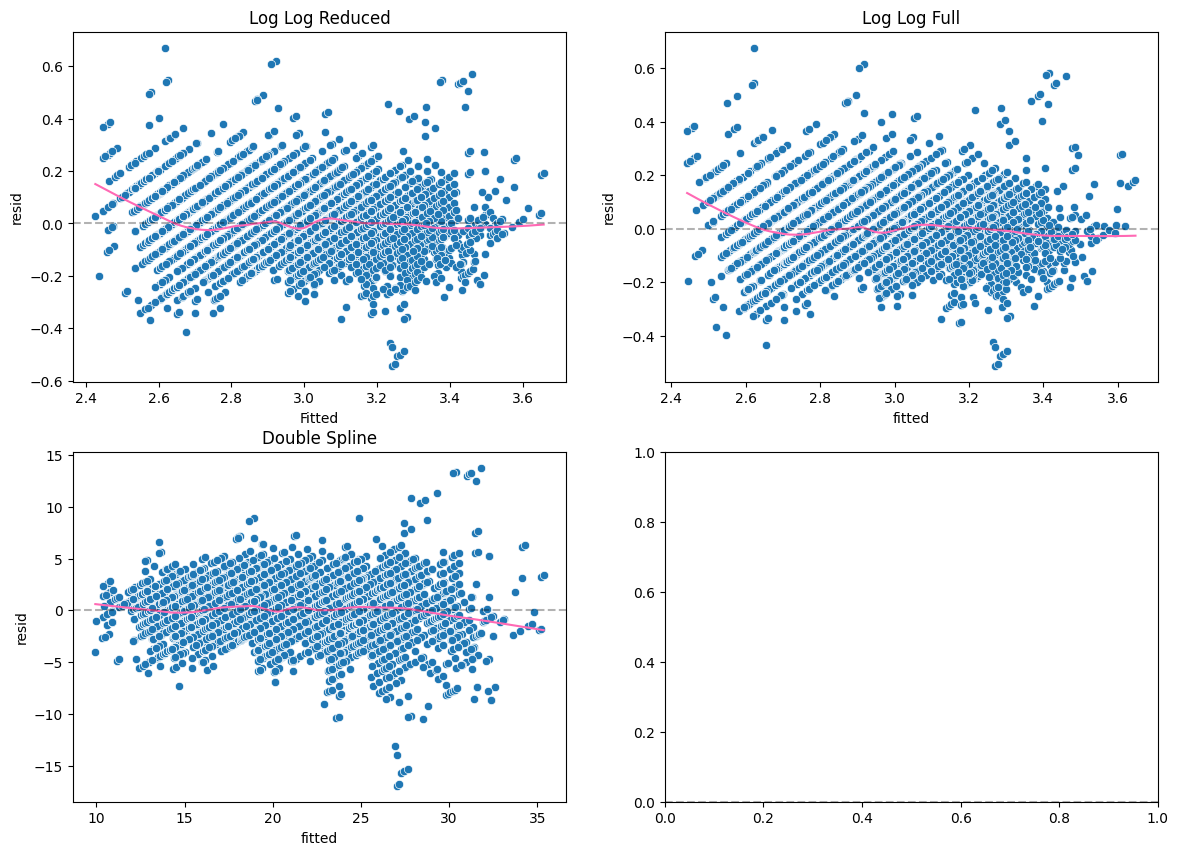

In [ ]:
#plot linear-linear, linear-log, log-linear, log-log fitted vs resid
fig = plt.figure(figsize=(14,10))
ax1 = fig.add_subplot(2,2,1)
ax2 = fig.add_subplot(2,2,2)
ax3 = fig.add_subplot(2,2,3)
ax4 = fig.add_subplot(2,2,4)
#ax1 = sns.scatterplot(ax=ax1,y=resid1, x=fitted1)
ax1.set(title='Log Log Reduced', ylabel='resid', xlabel='Fitted')
ax1 = sns.scatterplot(ax=ax1,x=yp_llrr, y=resid_llr)
ax2.set(title='Log Log Full', ylabel='resid', xlabel='fitted')
ax2 = sns.scatterplot(ax=ax2,x=yp_llr, y=resid_ll)
ax3.set(title='Double Spline', ylabel='resid', xlabel='fitted')
ax3 = sns.scatterplot(ax=ax3,y=resid_spln, x=yp_sprr)
#ax4.set(title='Log-log', ylabel='resid', xlabel='fitted')
print(len(resid_llr))
print(len(yp_llrr))
#plot lowless
lowess = sm.nonparametric.lowess
z1 = lowess(resid_llr, yp_llrr, frac=1./5)
ax1.plot(z1[:,0],z1[:,1],'hotpink')
z2 = lowess(resid_ll, yp_llr, frac=1./5)
ax2.plot(z2[:,0],z2[:,1],'hotpink')
z3 = lowess(resid_spln, yp_sprr, frac=1./5)
ax3.plot(z3[:,0],z3[:,1],'hotpink')
#z4 = lowess(resid4, fitted4, frac=1./5)
#ax4.plot(z4[:,0],z4[:,1],'hotpink')

ax1.axhline(color='Black', alpha=0.3, linestyle='--')
ax2.axhline(color='Black', alpha=0.3, linestyle='--')
ax3.axhline(color='Black', alpha=0.3, linestyle='--')
ax4.axhline(color='Black', alpha=0.3, linestyle='--')
#plt.show()
len(resid_llr)